In [169]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
from typing import Union, Optional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tqdm import tqdm, trange
import pickle
import seaborn as sns
DEVICE = torch.device("cpu")

100%|██████████| 114/114 [00:00<00:00, 243.36it/s]


(DefaultActor pid=32129)  Training loss for epoch 2: 1.2300354132526798, accuracy: 0.5614035087719298


In [140]:
with open('./data/classification_data.pkl', 'rb') as f:
            data = pickle.load(f)

In [141]:
l2idx = {l:i for i, l in enumerate(set([y for _, y in data['Consumer1']]))}

In [163]:
l2idx

{'Kettle': 0,
 'Lighting': 1,
 'Refrigerator': 2,
 'Water heater': 3,
 'Washing Machine': 4,
 'Microwave': 5,
 'TV': 6,
 'Dryer': 7,
 'AC': 8,
 'Dish washer': 9}

In [206]:
class ClassificationData(Dataset):
    def __init__(self, data):
        self.x = [x for x, _ in data]
        self.Y = [y for _, y in data]
        self.l2idx = {l:i for i, l in enumerate(sorted(list(set(self.Y))))}
        self.idx2l = {i:l for l, i in l2idx.items()}
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, i):
        return torch.tensor(self.x[i], dtype=torch.float), torch.tensor(self.l2idx[self.Y[i]], dtype=torch.long)

(DefaultActor pid=32839) /opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(DefaultActor pid=32839)   warnings.warn('resource_tracker: There appear to be %d '


In [143]:
data_plus = []
for consumer in data:
    data_plus += data[consumer]

In [144]:
train_data = ClassificationData(data_plus)

In [249]:
class MultiToOneRNN(nn.Module):
    def __init__(self, hidden_size, num_layers=2, output_size=10, LSTM=False, bidirectional=False):
        super(MultiToOneRNN, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = LSTM
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.directions = 1 if not self.bidirectional else 2
        if LSTM:
            self.rnn = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        else:
            self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
            
        self.fc1 = nn.Linear(self.hidden_size*self.directions, output_size)
        #self.fc2 = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, inputs, hidden_state, cell=None):
        if self.LSTM:
            output, (hidden_states, cell) = self.rnn(inputs, (hidden_state, cell))
        else:
            output, hidden_states = self.rnn(inputs, hidden_state)
        output = self.fc1(output)
        return output, hidden_states, cell

In [146]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)

In [244]:
epochs = 5
def train(net, train_loader):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
    num_layers = net.num_layers
    batch_size = train_loader.batch_size
    val_losses = []
    directions = 1 if not net.bidirectional else 2
    for epoch in range(epochs):
        net.train()
        total_loss = 0.0
        golds = []
        preds = []
        for x, Y in tqdm(train_loader):
            Y = Y.to(DEVICE)
            x = x.to(DEVICE).view(batch_size, -1, 1)
            hidden = torch.zeros((num_layers*directions, batch_size, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers*directions, batch_size, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            loss = criterion(outs[:, -1], Y)    
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = torch.argmax((F.softmax(outs[:, -1], dim=-1)), dim=-1)
            preds += pred.tolist()
            golds += Y.tolist()
            optimizer.zero_grad()
        val_losses.append(total_loss / len(train_loader))
        acc = np.mean((np.array(golds) == np.array(preds)))
        print(f' Training loss for epoch {epoch}: {total_loss / len(train_loader)}, accuracy: {acc}')
       
    return val_losses

# Non-Federated learning (Try to just fit the train set)

In [217]:
model = MultiToOneRNN(64, LSTM=False, bidirectional=True).to(DEVICE)

In [102]:
losses = train(model, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 151.15it/s]


 Training loss for epoch 0: 2.094950842077711, accuracy: 0.21343556002448194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 150.81it/s]


 Training loss for epoch 1: 1.607715711181289, accuracy: 0.38457418903558627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:16<00:00, 150.19it/s]


 Training loss for epoch 2: 1.7438761805429048, accuracy: 0.3480097490600682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 151.16it/s]


 Training loss for epoch 3: 1.6623926477185431, accuracy: 0.37561204861414704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 151.03it/s]


 Training loss for epoch 4: 1.8979691659340003, accuracy: 0.28338397306986096


  4%|███████████▊                                                                                                                                                                                                                                                                        | 487/11437 [00:03<01:13, 149.85it/s]


KeyboardInterrupt: 

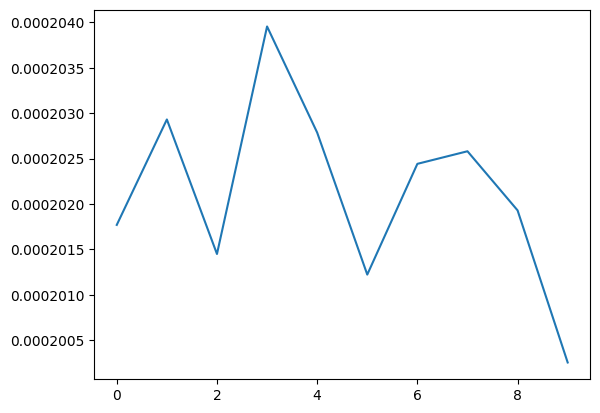

In [103]:
plt.plot(losses)

# Federated learning

In [250]:
batch_size = 8
hidden_size = 256
learning_rate = 3e-5

In [251]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [252]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset
        self.losses = []

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.dataset)
        self.losses = loss
        return get_parameters(self.net), len(self.dataset), {'loss': np.mean(loss)}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        return 0.0, 1, {}


def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    cid = int(cid) + 1
    net = MultiToOneRNN(hidden_size=hidden_size, LSTM=True).to(DEVICE)
    d = ClassificationData(data[f'Consumer{cid}'])
    train_loader = DataLoader(d, batch_size=batch_size, shuffle=True, drop_last=True)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader)


class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]],
    ):
        """Aggregate model weights using weighted average and store checkpoint"""
        net = MultiToOneRNN(hidden_size=hidden_size, LSTM=True).to(DEVICE)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...", flush=True)

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(net.state_dict(), f"model_round_{server_round}.pth")
            print(f"Saved round {server_round} aggregated_parameters!", flush=True)


        return aggregated_parameters, aggregated_metrics

def agg(metrics):
    losses = np.mean([m[-1]["loss"] for m in metrics])
    return {'losses': losses}



In [253]:
# Create FedAvg strategy
strategy = SaveModelStrategy(
    fraction_fit=0.25,  # Sample 100% of available clients for training
    fraction_evaluate=0.0,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=0,  # Never sample less than 5 clients for evaluation
    min_available_clients=40,  # Wait until all 10 clients are available
    fit_metrics_aggregation_fn= agg
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
res = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-03 10:41:04,323 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-11-03 10:41:07,935	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2023-11-03 10:41:08,461 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 8868143104.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8868143104.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0}
INFO flwr 2023-11-03 10:41:08,461 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-03 10:41:08,462 | app.py:224 | Flower VCE: Resources for each Virtual Client

(DefaultActor pid=34021)  Training loss for epoch 0: 2.3048451009412303, accuracy: 0.08944201312910284


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 2.3070254393688177, accuracy: 0.09682713347921225
(DefaultActor pid=34019)  Training loss for epoch 0: 2.3072492173777106, accuracy: 0.10092997811816193


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 2.305297689834361, accuracy: 0.10175054704595186 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 2.307101043100169, accuracy: 0.10229759299781181 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 1: 2.298008297152279, accuracy: 0.10175054704595186


 26%|██▌       | 118/457 [00:09<00:28, 11.78it/s] [repeated 167x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 2.304309229882071, accuracy: 0.09545951859956237


 95%|█████████▍| 434/457 [00:37<00:02,  8.49it/s] [repeated 28x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 2.2343219169120037, accuracy: 0.12554704595185995 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 2.295777413985922, accuracy: 0.11159737417943107 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 2.2923849805439587, accuracy: 0.11433260393873085
(DefaultActor pid=34016)  Training loss for epoch 2: 2.272645921362829, accuracy: 0.11351203501094093


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 2.3285781737229496, accuracy: 0.09108315098468271 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 2: 2.2922520642729243, accuracy: 0.12144420131291028 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 2.2777883012654745, accuracy: 0.12691466083150985


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 2.2542003737497645, accuracy: 0.14059080962800874


 99%|█████████▉| 453/457 [00:38<00:00, 12.08it/s] [repeated 46x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 2.303885591890932, accuracy: 0.09108315098468271 [repeated 3x across cluster]


 15%|█▌        | 70/457 [00:05<00:34, 11.25it/s] [repeated 219x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 2.2313490607806314, accuracy: 0.11761487964989059 [repeated 2x across cluster]


 39%|███▊      | 176/457 [00:14<00:23, 11.87it/s] [repeated 229x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 2.273863239152687, accuracy: 0.13047045951859956 [repeated 2x across cluster]


 18%|█▊        | 82/457 [00:06<00:29, 12.53it/s] [repeated 240x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 2.303305895636327, accuracy: 0.09600656455142231
(DefaultActor pid=34017)  Training loss for epoch 4: 2.3189130622396323, accuracy: 0.09272428884026258


 99%|█████████▊| 451/457 [00:37<00:00, 12.96it/s] [repeated 17x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 2.303153597291241, accuracy: 0.08834792122538293


 22%|██▏       | 99/457 [00:06<00:24, 14.62it/s] [repeated 208x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 2.307230652552465, accuracy: 0.10065645514223195


 66%|██████▌   | 300/457 [00:21<00:08, 18.18it/s] [repeated 132x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 2.230804533353259, accuracy: 0.1274617067833698 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 2.1632139359313496, accuracy: 0.17478118161925602 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 2.116414327329306, accuracy: 0.2013129102844639 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 2.3098604139144365, accuracy: 0.09190371991247265


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 2.112292184871448, accuracy: 0.2010393873085339


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.729551622982359, accuracy: 0.32685995623632386 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.74it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.6138283766855035, accuracy: 0.4075492341356674 [repeated 2x across cluster]


 99%|█████████▉| 452/457 [00:19<00:00, 25.06it/s] [repeated 12x across cluster]
DEBUG flwr 2023-11-03 10:46:06,034 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures


Saving round 1 aggregated_parameters...
Saved round 1 aggregated_parameters!


INFO flwr 2023-11-03 10:46:06,073 | server.py:171 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
DEBUG flwr 2023-11-03 10:46:06,073 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 2.0628370680485566, accuracy: 0.2327680525164114 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 2.2270732552008763, accuracy: 0.1463347921225383 [repeated 2x across cluster]


100%|█████████▉| 455/457 [00:38<00:00, 12.41it/s] [repeated 84x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 1.8851747053718149, accuracy: 0.26258205689277897 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.7502953664479162, accuracy: 0.3725382932166302 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 2.2566649744234146, accuracy: 0.11952954048140044 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 1.6987928607270806, accuracy: 0.35940919037199126 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.7579552895130683, accuracy: 0.3235776805251641 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 2: 2.2545478070069196, accuracy: 0.12144420131291028 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 2.0022385329073313, accuracy: 0.2773522975929978 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 2.2181157398015197, accuracy: 0.1526258205689278 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 2.252778119540058, accuracy: 0.112417943107221 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 2.2967335176154875, accuracy: 0.12390590809628009 [repeated 3x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.77it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 2.1841387699156414, accuracy: 0.15454048140043763 [repeated 3x across cluster]


100%|██████████| 457/457 [00:39<00:00, 11.56it/s]


(DefaultActor pid=34015)  Training loss for epoch 4: 2.25331748262276, accuracy: 0.11460612691466084 [repeated 2x across cluster]


 91%|█████████ | 415/457 [00:35<00:02, 14.93it/s] [repeated 201x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.9136501412422964, accuracy: 0.25547045951859954 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.9870762352870381, accuracy: 0.24726477024070023 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 2.3132294951173877, accuracy: 0.09792122538293217 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 2.3073847413845603, accuracy: 0.09272428884026258 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 2.3060575621915853, accuracy: 0.10421225382932166 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 21.80it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 2.3064754040549045, accuracy: 0.0938183807439825 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 10:51:03,951 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


Saving round 2 aggregated_parameters...
Saved round 2 aggregated_parameters!


INFO flwr 2023-11-03 10:51:04,004 | server.py:171 | evaluate_round 2: no clients selected, cancel
 91%|█████████ | 417/457 [00:18<00:01, 23.84it/s] [repeated 33x across cluster]
INFO:flwr:evaluate_round 2: no clients selected, cancel
DEBUG flwr 2023-11-03 10:51:04,005 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.736738098789357, accuracy: 0.34545951859956237 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 2.075791789353285, accuracy: 0.2210065645514223 [repeated 2x across cluster]


  0%|          | 1/457 [00:00<00:48,  9.31it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 1.9868172159341024, accuracy: 0.2508205689277899 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 2.307999620291545, accuracy: 0.09518599562363239
(DefaultActor pid=34016)  Training loss for epoch 1: 1.3620333217035498, accuracy: 0.49288840262582057


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 1: 2.3070040630824717, accuracy: 0.09080962800875274


  0%|          | 1/457 [00:00<00:48,  9.43it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 2.3141753824847533, accuracy: 0.10448577680525165


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 1.6793985571589982, accuracy: 0.3561269146608315 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 2.305859972663729, accuracy: 0.09819474835886215 [repeated 2x across cluster]


 98%|█████████▊| 447/457 [00:35<00:00, 12.18it/s] [repeated 15x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 2.305900185582935, accuracy: 0.09245076586433261 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 1.0375842033382057, accuracy: 0.5883479212253829 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 2.306623517293116, accuracy: 0.09299781181619256 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 2.305723364034941, accuracy: 0.09135667396061269 [repeated 2x across cluster]


 39%|███▉      | 180/457 [00:14<00:31,  8.86it/s] [repeated 183x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 2.0348319185640933, accuracy: 0.212527352297593 [repeated 2x across cluster]


  6%|▌         | 28/457 [00:02<00:34, 12.49it/s] [repeated 219x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 1.2729518073132053, accuracy: 0.4923413566739606 [repeated 2x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.72it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 2.305952145182069, accuracy: 0.09245076586433261 [repeated 2x across cluster]


100%|██████████| 457/457 [00:39<00:00, 11.64it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 2.3053055075639186, accuracy: 0.09327133479212253 [repeated 2x across cluster]


 96%|█████████▌| 439/457 [00:38<00:01, 17.19it/s] [repeated 45x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 2.273552995020242, accuracy: 0.12910284463894967 [repeated 3x across cluster]


 90%|████████▉ | 411/457 [00:26<00:02, 22.33it/s] [repeated 64x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.7431729006819443, accuracy: 0.36241794310722103 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.4245679786742647, accuracy: 0.46690371991247265 [repeated 2x across cluster]


 97%|█████████▋| 443/457 [00:20<00:00, 22.10it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.1408144711665564, accuracy: 0.5612691466083151 [repeated 2x across cluster]
(DefaultActor pid=34021) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.4261772551734808, accuracy: 0.4425601750547046 [repeated 2x across cluster]


 95%|█████████▍| 434/457 [00:20<00:01, 22.17it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.218438752500964, accuracy: 0.536925601750547 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 10:56:02,275 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


Saving round 3 aggregated_parameters...
Saved round 3 aggregated_parameters!


INFO flwr 2023-11-03 10:56:02,317 | server.py:171 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
DEBUG flwr 2023-11-03 10:56:02,318 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.3464355221918949, accuracy: 0.49015317286652077 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 1.3320065475918792, accuracy: 0.47921225382932164 [repeated 2x across cluster]


 98%|█████████▊| 447/457 [00:37<00:00, 13.00it/s] [repeated 66x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 1.948777150533914, accuracy: 0.23796498905908095 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.4272558942143714, accuracy: 0.4570568927789934 [repeated 3x across cluster]


 87%|████████▋ | 398/457 [00:32<00:04, 13.08it/s] [repeated 200x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 1.5793884866086347, accuracy: 0.44529540481400437 [repeated 2x across cluster]


 34%|███▍      | 156/457 [00:12<00:22, 13.18it/s] [repeated 158x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 1: 2.120832231164761, accuracy: 0.18408096280087527 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 1.107657294043827, accuracy: 0.5705689277899344 [repeated 2x across cluster]


 18%|█▊        | 82/457 [00:06<00:28, 13.28it/s] [repeated 249x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 1.930702494974992, accuracy: 0.3137308533916849 [repeated 2x across cluster]


 98%|█████████▊| 450/457 [00:38<00:00, 11.61it/s] [repeated 86x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 1.169000671128997, accuracy: 0.5467724288840262 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.4292934930168044, accuracy: 0.45650984682713347 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 1.533888727361316, accuracy: 0.4461159737417943 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 3: 2.087081077257966, accuracy: 0.21854485776805252 [repeated 4x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.87it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 1.3794727069804653, accuracy: 0.47702407002188185 [repeated 2x across cluster]


 24%|██▍       | 111/457 [00:09<00:27, 12.70it/s] [repeated 217x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 1.7148414974139607, accuracy: 0.36542669584245074 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 2.096751311284447, accuracy: 0.21936542669584244 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.5050968788645722, accuracy: 0.43900437636761486 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 1.196605400326998, accuracy: 0.5339168490153173 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.005035131191529, accuracy: 0.6072210065645515 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.32it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.9441842033937411, accuracy: 0.6269146608315098 [repeated 2x across cluster]


 91%|█████████ | 416/457 [00:19<00:01, 25.16it/s] [repeated 43x across cluster]
DEBUG flwr 2023-11-03 11:01:02,493 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


Saving round 4 aggregated_parameters...
Saved round 4 aggregated_parameters!


INFO flwr 2023-11-03 11:01:02,547 | server.py:171 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
DEBUG flwr 2023-11-03 11:01:02,547 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.3276078211269964, accuracy: 0.4737417943107221 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 1.1295321935897844, accuracy: 0.5609956236323851 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34015) 
(DefaultActor pid=34015)  Training loss for epoch 0: 1.3585956444886373, accuracy: 0.4608862144420131 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.649549709563704, accuracy: 0.39305251641137856
(DefaultActor pid=34021)  Training loss for epoch 1: 1.4983219003520858, accuracy: 0.425054704595186


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.9736662819101201, accuracy: 0.6143326039387309
(DefaultActor pid=34017)  Training loss for epoch 1: 0.9929685960452458, accuracy: 0.6239059080962801


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 2.2723087779280915, accuracy: 0.1351203501094092 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.9773652964073928, accuracy: 0.6143326039387309 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.7837498258448795, accuracy: 0.6835339168490153 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 2.250400406265676, accuracy: 0.13594091903719913 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.8831621662793065, accuracy: 0.6611050328227571 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 1.0845794425360222, accuracy: 0.561816192560175 [repeated 2x across cluster]


 98%|█████████▊| 446/457 [00:35<00:00, 12.88it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 1.6656856474260793, accuracy: 0.36980306345733044 [repeated 4x across cluster]


 98%|█████████▊| 446/457 [00:36<00:00, 13.16it/s] [repeated 15x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 1.4740143808285568, accuracy: 0.43435448577680524 [repeated 2x across cluster]


100%|██████████| 457/457 [00:39<00:00, 11.58it/s] [repeated 25x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 2.2031777915860684, accuracy: 0.17943107221006566 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.3725851686178203, accuracy: 0.48741794310722103 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 2.0093366278078677, accuracy: 0.22292122538293216 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 2.072313565133176, accuracy: 0.19611597374179432 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.9765690100792983, accuracy: 0.21690371991247265 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 22.36it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.965191687744608, accuracy: 0.22538293216630198 [repeated 2x across cluster]


 91%|█████████ | 415/457 [00:19<00:01, 24.48it/s] [repeated 37x across cluster]
DEBUG flwr 2023-11-03 11:06:01,614 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


Saving round 5 aggregated_parameters...
Saved round 5 aggregated_parameters!


INFO flwr 2023-11-03 11:06:01,661 | server.py:171 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
DEBUG flwr 2023-11-03 11:06:01,662 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 40)
 58%|█████▊    | 267/457 [00:22<00:12, 14.66it/s] [repeated 2x across cluster]


(DefaultActor pid=34016) 
(DefaultActor pid=34016)  Training loss for epoch 0: 0.8618668230246402, accuracy: 0.6548140043763676 [repeated 2x across cluster]


 96%|█████████▋| 441/457 [00:38<00:01, 11.69it/s] [repeated 33x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 1.1530863927673198, accuracy: 0.5393873085339168 [repeated 2x across cluster]


 99%|█████████▉| 454/457 [00:39<00:00, 12.38it/s] [repeated 74x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 1.0487976488321042, accuracy: 0.5768599562363238 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.845116281568091, accuracy: 0.675054704595186 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 1.1562405683149133, accuracy: 0.5522428884026258 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.7495879473845338, accuracy: 0.7084245076586433 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7295840518871074, accuracy: 0.7160831509846827 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 2: 1.1762695075776959, accuracy: 0.5514223194748359 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 1.004042146356544, accuracy: 0.5973741794310722 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.1054333531393525, accuracy: 0.5899890590809628


 98%|█████████▊| 450/457 [00:37<00:00, 11.11it/s] [repeated 26x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.863173725519582, accuracy: 0.650984682713348


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 1.5138840374070133, accuracy: 0.4365426695842451


 27%|██▋       | 122/457 [00:10<00:31, 10.67it/s] [repeated 168x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 1.07808339134413, accuracy: 0.5960065645514223


 45%|████▌     | 207/457 [00:17<00:18, 13.68it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.976221422088094, accuracy: 0.6020240700218819 [repeated 4x across cluster]


 97%|█████████▋| 443/457 [00:35<00:01, 12.65it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.8584251214691012, accuracy: 0.6838074398249453


 99%|█████████▉| 452/457 [00:37<00:00,  9.00it/s] [repeated 25x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.818918894772587, accuracy: 0.6649343544857768


100%|██████████| 457/457 [00:36<00:00, 12.47it/s] [repeated 20x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 1.573377314229502, accuracy: 0.3837527352297593
(DefaultActor pid=34020)  Training loss for epoch 4: 0.9967754854284699, accuracy: 0.6222647702407003


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.4923860085088785, accuracy: 0.43681619256017507 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.4844408093969983, accuracy: 0.4075492341356674 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 1.3717211711850157, accuracy: 0.44173960612691465 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.2405328284011627, accuracy: 0.48577680525164113 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 20.93it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 1.3086497419772576, accuracy: 0.45459518599562365 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 11:11:09,787 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


Saving round 6 aggregated_parameters...
Saved round 6 aggregated_parameters!


INFO flwr 2023-11-03 11:11:09,842 | server.py:171 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
DEBUG flwr 2023-11-03 11:11:09,843 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.6011312825674562, accuracy: 0.3572210065645514 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 0: 1.1754943611063633, accuracy: 0.5027352297592997 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.7418442014401017, accuracy: 0.3049781181619256 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 1.1558450227623696, accuracy: 0.5090262582056893 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.9799472180152357, accuracy: 0.6219912472647703 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.7877998903752417, accuracy: 0.31482494529540483 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.648513540821211, accuracy: 0.7434354485776805 [repeated 2x across cluster]


 54%|█████▍    | 248/457 [00:19<00:16, 12.61it/s] [repeated 206x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.8566540457650661, accuracy: 0.6580962800875274 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.5824391429742526, accuracy: 0.35038293216630195 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.938565292295794, accuracy: 0.661925601750547 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.7437413720581151, accuracy: 0.7305798687089715 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.8476905299256876, accuracy: 0.6646608315098468 [repeated 2x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.76it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.5776684578320652, accuracy: 0.35585339168490154 [repeated 2x across cluster]


100%|██████████| 457/457 [00:37<00:00, 12.06it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7382126824616473, accuracy: 0.7086980306345733


100%|██████████| 457/457 [00:38<00:00, 11.85it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.8500254655366914, accuracy: 0.6646608315098468


 99%|█████████▊| 451/457 [00:39<00:00, 13.17it/s] [repeated 40x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.660256367951175, accuracy: 0.7576586433260394 [repeated 2x across cluster]


 95%|█████████▌| 436/457 [00:37<00:01, 17.51it/s] [repeated 33x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.187550313167551, accuracy: 0.5508752735229759 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.7761957963003372, accuracy: 0.6895514223194749


  2%|▏         | 9/457 [00:00<00:20, 21.81it/s] [repeated 59x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.0073797671161022, accuracy: 0.5995623632385121


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.8213432806847654, accuracy: 0.674781181619256
(DefaultActor pid=34016)  Training loss for epoch 1: 0.9547639683182443, accuracy: 0.6167943107221007


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.0603336106570074, accuracy: 0.5850656455142232


  9%|▉         | 42/457 [00:01<00:19, 21.53it/s] [repeated 52x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.9630721156165427, accuracy: 0.62554704595186


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.4631558106947258, accuracy: 0.45842450765864334


  3%|▎         | 12/457 [00:00<00:20, 21.81it/s] [repeated 59x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.9632521685155789, accuracy: 0.6200765864332604


100%|██████████| 457/457 [00:21<00:00, 20.89it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.9459374863939682, accuracy: 0.24781181619256018


DEBUG flwr 2023-11-03 11:16:13,248 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


Saving round 7 aggregated_parameters...
Saved round 7 aggregated_parameters!


INFO flwr 2023-11-03 11:16:13,299 | server.py:171 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
DEBUG flwr 2023-11-03 11:16:13,300 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34016)  Training loss for epoch 4: 1.5221997779229537, accuracy: 0.4346280087527352


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.951296920284906, accuracy: 0.6208971553610503
(DefaultActor pid=34021)  Training loss for epoch 0: 1.0392973544300255, accuracy: 0.5951859956236324


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.7707185284183635, accuracy: 0.712800875273523


 99%|█████████▉| 452/457 [00:38<00:00, 12.41it/s] [repeated 38x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 1.2145081161066922, accuracy: 0.5320021881838074


 96%|█████████▋| 440/457 [00:38<00:01, 12.05it/s] [repeated 73x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.8194999329631647, accuracy: 0.675328227571116 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9393949995848556, accuracy: 0.6280087527352297
(DefaultActor pid=34016)  Training loss for epoch 1: 1.892736016138899, accuracy: 0.2809080962800875


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.7346784480372587, accuracy: 0.7322210065645515


 21%|██        | 95/457 [00:07<00:25, 14.12it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 1.0755022585848488, accuracy: 0.5785010940919038


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.9391985892010466, accuracy: 0.6271881838074398 [repeated 5x across cluster]


 99%|█████████▊| 451/457 [00:38<00:00, 12.62it/s]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.7203958644501098, accuracy: 0.7415207877461707 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 1.0111883260326, accuracy: 0.6113238512035011 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9280781813732122, accuracy: 0.637582056892779 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.7325642708387364, accuracy: 0.7117067833698031 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 1.529611712472444, accuracy: 0.4198577680525164 [repeated 3x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.92it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.4433761210358116, accuracy: 0.4551422319474836 [repeated 3x across cluster]


 95%|█████████▍| 434/457 [00:34<00:01, 13.13it/s] [repeated 9x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.6114250721014564, accuracy: 0.7642231947483589 [repeated 2x across cluster]


 47%|████▋     | 214/457 [00:16<00:12, 18.94it/s] [repeated 167x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 1.0572852362884735, accuracy: 0.598741794310722 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.9544228109280443, accuracy: 0.6167943107221007 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.2450806429809371, accuracy: 0.512855579868709 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.1123846937256257, accuracy: 0.5585339168490153 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.2594565192249725, accuracy: 0.5314551422319475 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 20.93it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.1318227330169741, accuracy: 0.5653719912472648 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 11:21:17,963 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


Saving round 8 aggregated_parameters...
Saved round 8 aggregated_parameters!


INFO flwr 2023-11-03 11:21:18,013 | server.py:171 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
DEBUG flwr 2023-11-03 11:21:18,014 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.002959782367723, accuracy: 0.599015317286652 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.8418718314519726, accuracy: 0.6739606126914661 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.9458804951585357, accuracy: 0.6167943107221007 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.7513711896742321, accuracy: 0.7045951859956237 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.9485730065167342, accuracy: 0.6167943107221007 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.5713823987354465, accuracy: 0.7778993435448578 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 1.565253963877388, accuracy: 0.35311816192560175 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.3796082441603328, accuracy: 0.5027352297592997 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.5504405329134356, accuracy: 0.7896608315098468 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.9732549527183143, accuracy: 0.5910831509846827 [repeated 2x across cluster]


 67%|██████▋   | 304/457 [00:24<00:11, 12.84it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 1.092138891342693, accuracy: 0.5768599562363238 [repeated 4x across cluster]


100%|██████████| 457/457 [00:37<00:00, 12.12it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.5491008716849386, accuracy: 0.7923960612691466 [repeated 2x across cluster]


100%|██████████| 457/457 [00:39<00:00, 11.62it/s]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.710918741687904, accuracy: 0.7303063457330415


 44%|████▎     | 199/457 [00:15<00:19, 13.35it/s]


(DefaultActor pid=34015)  Training loss for epoch 4: 1.0785537706423118, accuracy: 0.574398249452954


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.6436305287980864, accuracy: 0.7543763676148797 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.7628809336320185, accuracy: 0.7169037199124726 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 2.2132709373269615, accuracy: 0.14907002188183807 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 2.2378729425321784, accuracy: 0.137582056892779 [repeated 2x across cluster]


 98%|█████████▊| 449/457 [00:20<00:00, 21.90it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 2.192050371180478, accuracy: 0.16219912472647702 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 11:26:18,252 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


Saving round 9 aggregated_parameters...
Saved round 9 aggregated_parameters!


INFO flwr 2023-11-03 11:26:18,303 | server.py:171 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
DEBUG flwr 2023-11-03 11:26:18,304 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.67814784257365, accuracy: 0.7344091903719913 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.5923627812203419, accuracy: 0.7699671772428884 [repeated 2x across cluster]


 96%|█████████▌| 439/457 [00:36<00:01, 12.34it/s] [repeated 62x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.978385849107929, accuracy: 0.6157002188183808 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.6231962144680533, accuracy: 0.7595733041575492 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.5830128010590632, accuracy: 0.774617067833698 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 1.1507905606726587, accuracy: 0.5782275711159738 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.61294995124515, accuracy: 0.7584792122538293 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 1.1782376095815612, accuracy: 0.5415754923413567 [repeated 2x across cluster]


 98%|█████████▊| 449/457 [00:38<00:00, 12.61it/s] [repeated 57x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 1.0874239393801344, accuracy: 0.5530634573304157 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.6330441017543461, accuracy: 0.7521881838074398


 68%|██████▊   | 309/457 [00:24<00:10, 14.32it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.6007859290295221, accuracy: 0.7934901531728665


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 1.0584056908570443, accuracy: 0.5845185995623632
(DefaultActor pid=34018)  Training loss for epoch 3: 1.0498104928880605, accuracy: 0.5883479212253829


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 3: 1.0883076892965993, accuracy: 0.5850656455142232 [repeated 3x across cluster]


100%|██████████| 457/457 [00:36<00:00, 12.47it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.6316421055428569, accuracy: 0.7587527352297593 [repeated 2x across cluster]


 13%|█▎        | 58/457 [00:05<00:31, 12.80it/s] [repeated 186x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.9532434142865159, accuracy: 0.6228118161925602 [repeated 2x across cluster]


 45%|████▌     | 207/457 [00:15<00:19, 12.53it/s] [repeated 145x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 1.2138534373801437, accuracy: 0.5656455142231948 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.2006867208581262, accuracy: 0.5051969365426696 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.1868902458208135, accuracy: 0.5016411378555798 [repeated 2x across cluster]
(DefaultActor pid=34021) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.1874714207466635, accuracy: 0.5114879649890591 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.4741590240852056, accuracy: 0.44173960612691465 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.57it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.3486580785763342, accuracy: 0.4783916849015317 [repeated 2x across cluster]


 98%|█████████▊| 449/457 [00:20<00:00, 25.20it/s] [repeated 11x across cluster]
DEBUG flwr 2023-11-03 11:31:22,686 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


Saving round 10 aggregated_parameters...
Saved round 10 aggregated_parameters!


INFO flwr 2023-11-03 11:31:22,748 | server.py:171 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
DEBUG flwr 2023-11-03 11:31:22,749 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6589292174315231, accuracy: 0.7718818380743983 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.6579465425045472, accuracy: 0.7385120350109409 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5891729809702486, accuracy: 0.7861050328227571 [repeated 6x across cluster]


 84%|████████▍ | 386/457 [00:33<00:05, 13.14it/s] [repeated 213x across cluster]


(DefaultActor pid=34017) 
(DefaultActor pid=34017)  Training loss for epoch 1: 0.9755594844173812, accuracy: 0.62527352297593 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.6106518950533424, accuracy: 0.7836433260393874 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.9198886359220522, accuracy: 0.6329321663019694 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.6186920290311525, accuracy: 0.7571115973741794 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.499800971833504, accuracy: 0.8298687089715536 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.90907663950611, accuracy: 0.638402625820569 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 3: 1.1048148600282697, accuracy: 0.5358315098468271
(DefaultActor pid=34018)  Training loss for epoch 3: 1.5644140754799873, accuracy: 0.3564004376367615


  7%|▋         | 30/457 [00:02<00:35, 12.15it/s] [repeated 209x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.5348609510291555, accuracy: 0.7926695842450766 [repeated 3x across cluster]


 92%|█████████▏| 422/457 [00:33<00:02, 12.81it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5842850170912388, accuracy: 0.8164660831509847


 38%|███▊      | 172/457 [00:14<00:23, 12.08it/s] [repeated 213x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.518198411696727, accuracy: 0.8285010940919038


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.9364527986268768, accuracy: 0.6342997811816192


 82%|████████▏ | 377/457 [00:32<00:06, 12.47it/s] [repeated 224x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 1.1594263095433133, accuracy: 0.5166849015317286


 99%|█████████▉| 452/457 [00:37<00:00, 16.26it/s] [repeated 49x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.5483613558708643, accuracy: 0.7956783369803063 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6076593444085552, accuracy: 0.7822757111597374
(DefaultActor pid=34021)  Training loss for epoch 0: 0.9185184889210132, accuracy: 0.6345733041575492


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.600882420991904, accuracy: 0.7929431072210066
(DefaultActor pid=34021)  Training loss for epoch 1: 0.887802978957182, accuracy: 0.6452407002188184


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.5572822143882106, accuracy: 0.8096280087527352
(DefaultActor pid=34021)  Training loss for epoch 2: 0.8963760091908912, accuracy: 0.6400437636761488


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.521948520465055, accuracy: 0.8276805251641138


  5%|▍         | 21/457 [00:00<00:20, 21.65it/s] [repeated 52x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.0140263175742632, accuracy: 0.611597374179431


100%|██████████| 457/457 [00:21<00:00, 21.37it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.46944182169984383, accuracy: 0.8443654266958425


DEBUG flwr 2023-11-03 11:36:24,826 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


Saving round 11 aggregated_parameters...
Saved round 11 aggregated_parameters!


INFO flwr 2023-11-03 11:36:24,884 | server.py:171 | evaluate_round 11: no clients selected, cancel
INFO:flwr:evaluate_round 11: no clients selected, cancel
DEBUG flwr 2023-11-03 11:36:24,885 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34021)  Training loss for epoch 4: 0.955709855979068, accuracy: 0.6258205689277899


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.0890809143659061, accuracy: 0.5552516411378556


 82%|████████▏ | 375/457 [00:31<00:06, 12.54it/s] [repeated 212x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.5177726178008174, accuracy: 0.8077133479212254


 95%|█████████▍| 434/457 [00:37<00:02,  8.85it/s] [repeated 24x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.5383115814737894, accuracy: 0.8025164113785558


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.8177956187245752, accuracy: 0.6849015317286652


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 0: 0.7054689752520826, accuracy: 0.7456236323851203 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.072614412738471, accuracy: 0.5547045951859956 [repeated 3x across cluster]


100%|██████████| 457/457 [00:39<00:00, 11.62it/s] [repeated 45x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.8142217405408384, accuracy: 0.6925601750547046 [repeated 2x across cluster]


 96%|█████████▋| 440/457 [00:38<00:01, 11.50it/s] [repeated 69x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 1.7793794855377607, accuracy: 0.3282275711159737 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.2439783805700046, accuracy: 0.5207877461706784 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.4641637085912509, accuracy: 0.8367067833698031


 91%|█████████ | 417/457 [00:37<00:03, 11.77it/s] [repeated 195x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.7809882344315298, accuracy: 0.7073304157549234


 54%|█████▍    | 249/457 [00:19<00:14, 13.95it/s] [repeated 187x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.5128341626999513, accuracy: 0.8361597374179431 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.2096912116790497, accuracy: 0.5117614879649891


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.48347873004312325, accuracy: 0.8345185995623632


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.6989325136700298, accuracy: 0.7601203501094091
(DefaultActor pid=34020)  Training loss for epoch 3: 0.7921696379454705, accuracy: 0.7007658643326039


 62%|██████▏   | 284/457 [00:23<00:13, 13.30it/s] [repeated 187x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.5098693377483041, accuracy: 0.8342450765864332 [repeated 4x across cluster]


100%|██████████| 457/457 [00:36<00:00, 12.38it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.098071315617217, accuracy: 0.549781181619256


100%|██████████| 457/457 [00:37<00:00, 12.11it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.45400872005810006, accuracy: 0.8416301969365426


 99%|█████████▉| 454/457 [00:38<00:00, 13.53it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.8235147636041403, accuracy: 0.7324945295404814


 97%|█████████▋| 444/457 [00:39<00:01, 12.44it/s] [repeated 19x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.7830434871319869, accuracy: 0.7018599562363238


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.8494589424954984, accuracy: 0.6485229759299781 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.7889007621931821, accuracy: 0.6687636761487965 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.9133135972124742, accuracy: 0.300328227571116 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 2.2223761326896283, accuracy: 0.150164113785558 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.5754146522697656, accuracy: 0.7926695842450766


100%|██████████| 457/457 [00:21<00:00, 21.54it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 2.2671494820446623, accuracy: 0.13293216630196936


 99%|█████████▉| 454/457 [00:20<00:00, 24.25it/s]
DEBUG flwr 2023-11-03 11:41:31,033 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


Saving round 12 aggregated_parameters...
Saved round 12 aggregated_parameters!


100%|██████████| 457/457 [00:20<00:00, 22.09it/s]
INFO flwr 2023-11-03 11:41:31,090 | server.py:171 | evaluate_round 12: no clients selected, cancel
INFO:flwr:evaluate_round 12: no clients selected, cancel
DEBUG flwr 2023-11-03 11:41:31,091 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5595058494082426, accuracy: 0.8022428884026258


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.5795959049216278, accuracy: 0.8181072210065645


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.818498476989225, accuracy: 0.6728665207877462 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.7472514397254788, accuracy: 0.7193654266958425 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.5817444444485254, accuracy: 0.35120350109409193
(DefaultActor pid=34016)  Training loss for epoch 1: 0.5259944441701802, accuracy: 0.8317833698030634


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.7856489563324128, accuracy: 0.6854485776805251
(DefaultActor pid=34019)  Training loss for epoch 1: 0.41948686073803193, accuracy: 0.8632385120350109


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.5647652544390973, accuracy: 0.3640590809628009 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.7856689504545419, accuracy: 0.6832603938730853 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.842195832535331, accuracy: 0.6679431072210066 [repeated 4x across cluster]
(DefaultActor pid=34020) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.5520434641733734, accuracy: 0.3514770240700219 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.5063253516775579, accuracy: 0.8421772428884027


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.40832108356205327, accuracy: 0.861597374179431


 98%|█████████▊| 449/457 [00:38<00:00, 10.77it/s] [repeated 47x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 1.0557397461172267, accuracy: 0.6064004376367614 [repeated 4x across cluster]


100%|██████████| 457/457 [00:36<00:00, 12.56it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.580377704596363, accuracy: 0.3588621444201313 [repeated 2x across cluster]


100%|██████████| 457/457 [00:38<00:00, 11.92it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5026988131962146, accuracy: 0.8405361050328227


100%|██████████| 457/457 [00:40<00:00, 11.30it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.40247716934061495, accuracy: 0.8643326039387309


 93%|█████████▎| 423/457 [00:39<00:03, 10.64it/s]


(DefaultActor pid=34015) 


 93%|█████████▎| 426/457 [00:38<00:02, 15.10it/s] [repeated 63x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.7038722458077469, accuracy: 0.7349562363238512 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.0389571733104321, accuracy: 0.5692013129102844 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.0226726179180312, accuracy: 0.574398249452954 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.0039029800265833, accuracy: 0.5771334792122538 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.0396563995148604, accuracy: 0.5708424507658644 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.69it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.0014904597794527, accuracy: 0.5793216630196937 [repeated 2x across cluster]


 91%|█████████ | 416/457 [00:18<00:01, 24.96it/s] [repeated 44x across cluster]
DEBUG flwr 2023-11-03 11:46:36,165 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


Saving round 13 aggregated_parameters...
Saved round 13 aggregated_parameters!


INFO flwr 2023-11-03 11:46:36,226 | server.py:171 | evaluate_round 13: no clients selected, cancel
INFO:flwr:evaluate_round 13: no clients selected, cancel
DEBUG flwr 2023-11-03 11:46:36,226 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.4329777599090233, accuracy: 0.8481947483588621 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.9948196683274643, accuracy: 0.6096827133479212 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 1.017630157331708, accuracy: 0.5779540481400438 [repeated 3x across cluster]


 62%|██████▏   | 285/457 [00:25<00:13, 12.37it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.40699660577923386, accuracy: 0.8569474835886215 [repeated 3x across cluster]


 92%|█████████▏| 422/457 [00:38<00:03,  9.93it/s] [repeated 3x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.9610743812923228, accuracy: 0.62554704595186 [repeated 2x across cluster]


 25%|██▌       | 115/457 [00:09<00:27, 12.39it/s] [repeated 165x across cluster]


(DefaultActor pid=34018) 


 12%|█▏        | 54/457 [00:04<00:31, 12.76it/s] [repeated 182x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 1.1446627123318043, accuracy: 0.5670131291028446 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.4010011937379576, accuracy: 0.8610503282275711
(DefaultActor pid=34021)  Training loss for epoch 2: 0.42811749352211503, accuracy: 0.8643326039387309


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.620981212677862, accuracy: 0.7844638949671773
(DefaultActor pid=34018)  Training loss for epoch 2: 0.8747465547655161, accuracy: 0.637308533916849


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 1.0180735124083524, accuracy: 0.5785010940919038 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.503306896783436, accuracy: 0.8334245076586433
(DefaultActor pid=34021)  Training loss for epoch 3: 0.4088915463366813, accuracy: 0.8785557986870897


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.5820560077352029, accuracy: 0.7891137855579868
(DefaultActor pid=34018)  Training loss for epoch 3: 0.8615607837545206, accuracy: 0.6446936542669585


 46%|████▌     | 208/457 [00:16<00:19, 12.54it/s] [repeated 192x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.6323577260468114, accuracy: 0.774070021881838 [repeated 3x across cluster]


 94%|█████████▎| 428/457 [00:34<00:02, 13.14it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7685954255628638, accuracy: 0.7393326039387309 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.8459033018051437, accuracy: 0.7032275711159738 [repeated 2x across cluster]


 88%|████████▊ | 400/457 [00:34<00:03, 17.73it/s] [repeated 2x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.3909576182076361, accuracy: 0.8681619256017505 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.45675551182645446, accuracy: 0.8438183807439825 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.40350520590939754, accuracy: 0.8542122538293216 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.4356357308239136, accuracy: 0.8514770240700219 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.7588819419023636, accuracy: 0.6925601750547046 [repeated 2x across cluster]


 91%|█████████ | 416/457 [00:19<00:01, 22.00it/s] [repeated 64x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.8165996223443577, accuracy: 0.6728665207877462 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 11:51:41,585 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


Saving round 14 aggregated_parameters...
Saved round 14 aggregated_parameters!


INFO flwr 2023-11-03 11:51:41,636 | server.py:171 | evaluate_round 14: no clients selected, cancel
INFO:flwr:evaluate_round 14: no clients selected, cancel
DEBUG flwr 2023-11-03 11:51:41,636 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.4451072802495543, accuracy: 0.8429978118161926 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 1.6147786155832153, accuracy: 0.35585339168490154 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.429561720560622, accuracy: 0.8451859956236324 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.6065828753492634, accuracy: 0.7830962800875274 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.5416072337405198, accuracy: 0.8016958424507659 [repeated 5x across cluster]


 99%|█████████▉| 452/457 [00:35<00:00, 13.25it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.41119091158725896, accuracy: 0.8531181619256017


 98%|█████████▊| 446/457 [00:35<00:00, 13.45it/s] [repeated 17x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.6215116488594455, accuracy: 0.7675054704595186


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.8231413141096773, accuracy: 0.6739606126914661
(DefaultActor pid=34019)  Training loss for epoch 2: 0.6769309729007552, accuracy: 0.7655908096280087


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34020) 
(DefaultActor pid=34020)  Training loss for epoch 2: 0.8567470748067163, accuracy: 0.649070021881838 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3970051461573959, accuracy: 0.8577680525164114 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.8595184207582108, accuracy: 0.6567286652078774 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 1.541890462196108, accuracy: 0.36706783369803064 [repeated 2x across cluster]


 78%|███████▊  | 357/457 [00:27<00:11,  8.78it/s]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.5541195858869074, accuracy: 0.7959518599562363 [repeated 3x across cluster]


 14%|█▍        | 63/457 [00:05<00:52,  7.54it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.3986381514963879, accuracy: 0.8599562363238512


  6%|▋         | 29/457 [00:02<00:30, 14.03it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.6113365229414837, accuracy: 0.7705142231947484


100%|██████████| 457/457 [00:38<00:00, 11.86it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.7859701537374301, accuracy: 0.688457330415755


 95%|█████████▌| 436/457 [00:38<00:02,  9.51it/s]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.6176192943226848, accuracy: 0.7809080962800875


 75%|███████▌  | 345/457 [00:24<00:07, 15.55it/s] [repeated 95x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.7761192245315149, accuracy: 0.7415207877461707 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8446904256984722, accuracy: 0.6698577680525164 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.9283678047578064, accuracy: 0.6452407002188184 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.9793149518171077, accuracy: 0.6392231947483589 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.30it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.9638888140084707, accuracy: 0.6414113785557987 [repeated 2x across cluster]


 98%|█████████▊| 449/457 [00:20<00:00, 24.59it/s] [repeated 11x across cluster]
DEBUG flwr 2023-11-03 11:56:43,517 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


Saving round 15 aggregated_parameters...
Saved round 15 aggregated_parameters!


INFO flwr 2023-11-03 11:56:43,592 | server.py:171 | evaluate_round 15: no clients selected, cancel
INFO:flwr:evaluate_round 15: no clients selected, cancel
DEBUG flwr 2023-11-03 11:56:43,592 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.5933138455551614, accuracy: 0.35311816192560175 [repeated 2x across cluster]


 96%|█████████▌| 438/457 [00:37<00:01, 13.78it/s] [repeated 25x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.4354178251401079, accuracy: 0.8676148796498906 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.4229833725229756, accuracy: 0.8736323851203501 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.5694493389233979, accuracy: 0.3591356673960613 [repeated 2x across cluster]


 20%|█▉        | 90/457 [00:07<00:27, 13.15it/s] [repeated 216x across cluster]


(DefaultActor pid=34020) 
(DefaultActor pid=34020)  Training loss for epoch 1: 1.5493038883616157, accuracy: 0.35585339168490154 [repeated 2x across cluster]


 99%|█████████▉| 454/457 [00:39<00:00, 11.13it/s] [repeated 73x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.3932144008315763, accuracy: 0.8837527352297593 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.555599386862905, accuracy: 0.35804157549234134 [repeated 2x across cluster]


 98%|█████████▊| 450/457 [00:34<00:00, 14.45it/s] [repeated 26x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.9753629874837477, accuracy: 0.5954595185995624 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.6867273287272949, accuracy: 0.7417943107221007 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.5483218873616642, accuracy: 0.3591356673960613 [repeated 2x across cluster]


 31%|███       | 140/457 [00:10<00:21, 14.90it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.9774058733290343, accuracy: 0.5867067833698031 [repeated 2x across cluster]


 15%|█▍        | 68/457 [00:05<00:29, 12.97it/s] [repeated 185x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.3238927856188561, accuracy: 0.8935995623632386 [repeated 2x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.83it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.5536168458294817, accuracy: 0.3553063457330416 [repeated 4x across cluster]


100%|██████████| 457/457 [00:37<00:00, 12.12it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.9867709897442251, accuracy: 0.5886214442013129 [repeated 2x across cluster]


 94%|█████████▍| 431/457 [00:36<00:02, 12.80it/s]


(DefaultActor pid=34020)  Training loss for epoch 4: 2.160024197409398, accuracy: 0.175054704595186
(DefaultActor pid=34018)  Training loss for epoch 4: 0.33805563292951124, accuracy: 0.887855579868709


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.4966814517330366, accuracy: 0.8153719912472648 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5391795423281271, accuracy: 0.800601750547046 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.4879029737877164, accuracy: 0.8161925601750547 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.47768071452902094, accuracy: 0.8224835886214442 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.18it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.5062026740795641, accuracy: 0.8137308533916849 [repeated 2x across cluster]


 90%|█████████ | 412/457 [00:19<00:01, 24.43it/s] [repeated 53x across cluster]
DEBUG flwr 2023-11-03 12:01:45,720 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


Saving round 16 aggregated_parameters...
Saved round 16 aggregated_parameters!


INFO flwr 2023-11-03 12:01:45,778 | server.py:171 | evaluate_round 16: no clients selected, cancel
INFO:flwr:evaluate_round 16: no clients selected, cancel
DEBUG flwr 2023-11-03 12:01:45,779 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.5945653055704869, accuracy: 0.7910284463894968 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.7953723268501901, accuracy: 0.6892778993435449 [repeated 2x across cluster]


 15%|█▌        | 69/457 [00:06<00:55,  7.04it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.694733037707076, accuracy: 0.7409737417943107 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5815318053034471, accuracy: 0.7904814004376368
(DefaultActor pid=34016)  Training loss for epoch 1: 0.8003740022901478, accuracy: 0.6900984682713348


 81%|████████  | 368/457 [00:32<00:07, 11.39it/s] [repeated 181x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.9918575063347816, accuracy: 0.6159737417943107
(DefaultActor pid=34015)  Training loss for epoch 1: 0.7979668734138688, accuracy: 0.688183807439825


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.6870765517785722, accuracy: 0.7404266958424508 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7854685821678465, accuracy: 0.6939277899343544
(DefaultActor pid=34021)  Training loss for epoch 2: 0.5773370657151838, accuracy: 0.7923960612691466


 92%|█████████▏| 421/457 [00:35<00:02, 12.92it/s]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.960857500752161, accuracy: 0.6222647702407003
(DefaultActor pid=34017)  Training loss for epoch 2: 1.0219908989782505, accuracy: 0.5705689277899344


 20%|█▉        | 90/457 [00:08<00:53,  6.90it/s]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.6873661133845864, accuracy: 0.7428884026258206 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7793245045582843, accuracy: 0.6939277899343544
(DefaultActor pid=34021)  Training loss for epoch 3: 0.6498798349998581, accuracy: 0.7789934354485777


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 1.0173654843374467, accuracy: 0.5692013129102844


 71%|███████   | 324/457 [00:27<00:11, 11.89it/s] [repeated 213x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 1.0286122426814532, accuracy: 0.6099562363238512


 82%|████████▏ | 375/457 [00:32<00:08,  9.87it/s] [repeated 175x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.3121678315776072, accuracy: 0.8979759299781181 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.704987551683776, accuracy: 0.7382385120350109


 94%|█████████▍| 430/457 [00:34<00:02, 12.91it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7736844273010999, accuracy: 0.6966630196936543


 98%|█████████▊| 449/457 [00:37<00:00, 12.50it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 1.1000476784074855, accuracy: 0.5418490153172867 [repeated 2x across cluster]


 41%|████      | 187/457 [00:15<00:15, 17.55it/s]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.7256243447008944, accuracy: 0.7735229759299781 [repeated 3x across cluster]


 89%|████████▊ | 405/457 [00:33<00:03, 16.74it/s] [repeated 129x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.6715443474801025, accuracy: 0.7453501094091903 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.44893178574158044, accuracy: 0.8495623632385121
(DefaultActor pid=34016)  Training loss for epoch 0: 0.47083540811382757, accuracy: 0.8361597374179431


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.42690580763932545, accuracy: 0.850109409190372
(DefaultActor pid=34016)  Training loss for epoch 1: 0.467446079232355, accuracy: 0.837527352297593


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.41420599920124923, accuracy: 0.8539387308533917
(DefaultActor pid=34016)  Training loss for epoch 2: 0.45822015836176666, accuracy: 0.8386214442013129


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.5684927674675263, accuracy: 0.8044310722100656
(DefaultActor pid=34016)  Training loss for epoch 3: 0.473579911294004, accuracy: 0.8350656455142232


 92%|█████████▏| 419/457 [00:20<00:01, 21.48it/s]
DEBUG flwr 2023-11-03 12:06:49,888 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


(DefaultActor pid=34016)  Training loss for epoch 4: 0.4674614182400443, accuracy: 0.8361597374179431
Saving round 17 aggregated_parameters...
Saved round 17 aggregated_parameters!


INFO flwr 2023-11-03 12:06:49,948 | server.py:171 | evaluate_round 17: no clients selected, cancel
INFO:flwr:evaluate_round 17: no clients selected, cancel
DEBUG flwr 2023-11-03 12:06:49,949 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34021)  Training loss for epoch 4: 0.49210915036287556, accuracy: 0.8328774617067833


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.43099190965327955, accuracy: 0.850109409190372
(DefaultActor pid=34021)  Training loss for epoch 0: 0.4738361023777089, accuracy: 0.8347921225382933


  0%|          | 1/457 [00:00<00:47,  9.69it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.7840032632527894, accuracy: 0.7086980306345733
(DefaultActor pid=34018)  Training loss for epoch 0: 0.35684619139252266, accuracy: 0.8925054704595186


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.8373129008036245, accuracy: 0.674781181619256 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.4197066716760136, accuracy: 0.8528446389496718 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.3320843892124725, accuracy: 0.9037199124726477 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 1: 0.8502699579978341, accuracy: 0.6682166301969366 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.42592400495835153, accuracy: 0.8528446389496718 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.32938963518958414, accuracy: 0.9001641137855579 [repeated 2x across cluster]


100%|█████████▉| 455/457 [00:39<00:00, 11.65it/s] [repeated 31x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.817870506201616, accuracy: 0.6791575492341356 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.547193551941467, accuracy: 0.800328227571116


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3956400122823646, accuracy: 0.8640590809628009


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.3577140618036822, accuracy: 0.8944201312910285 [repeated 2x across cluster]


  4%|▍         | 19/457 [00:02<01:07,  6.52it/s]


(DefaultActor pid=34017) 


 98%|█████████▊| 449/457 [00:40<00:00, 11.99it/s] [repeated 16x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.8094644823449886, accuracy: 0.6780634573304157 [repeated 4x across cluster]


 52%|█████▏    | 238/457 [00:20<00:17, 12.69it/s] [repeated 211x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.5839903717249209, accuracy: 0.7934901531728665


100%|██████████| 457/457 [00:36<00:00, 12.35it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.4134972681346425, accuracy: 0.8580415754923414


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.3249742396110139, accuracy: 0.9001641137855579 [repeated 2x across cluster]


 94%|█████████▎| 428/457 [00:36<00:01, 15.14it/s] [repeated 42x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.8199447638597707, accuracy: 0.6761487964989059 [repeated 4x across cluster]


 93%|█████████▎| 426/457 [00:35<00:02, 14.46it/s] [repeated 18x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.5510168253496102, accuracy: 0.7978665207877462


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.707574561450231, accuracy: 0.7086980306345733


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.7300766017817825, accuracy: 0.7059628008752735 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.70904539853204, accuracy: 0.7108862144420132 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7112575630587067, accuracy: 0.7141684901531729 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.14it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.6870569587895072, accuracy: 0.7190919037199125 [repeated 2x across cluster]


 90%|████████▉ | 411/457 [00:19<00:02, 22.40it/s] [repeated 61x across cluster]
DEBUG flwr 2023-11-03 12:11:58,783 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


Saving round 18 aggregated_parameters...
Saved round 18 aggregated_parameters!


INFO flwr 2023-11-03 12:11:58,840 | server.py:171 | evaluate_round 18: no clients selected, cancel
INFO:flwr:evaluate_round 18: no clients selected, cancel
DEBUG flwr 2023-11-03 12:11:58,841 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.376417297038965, accuracy: 0.8935995623632386 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.8367109108223076, accuracy: 0.6682166301969366 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.5603691672669883, accuracy: 0.7970459518599562 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.3462667101352217, accuracy: 0.9018052516411379


 94%|█████████▍| 431/457 [00:37<00:01, 13.11it/s] [repeated 7x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.43286470003773536, accuracy: 0.8550328227571116


 91%|█████████▏| 418/457 [00:34<00:03, 12.68it/s] [repeated 21x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.8072592040220239, accuracy: 0.6854485776805251


 87%|████████▋ | 399/457 [00:35<00:04, 12.20it/s] [repeated 189x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 1: 0.4403756914300804, accuracy: 0.8353391684901532


  2%|▏         | 8/457 [00:00<00:34, 13.05it/s] [repeated 172x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.5471337354116353, accuracy: 0.8044310722100656 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.3411170088219114, accuracy: 0.9001641137855579


 64%|██████▎   | 291/457 [00:25<00:13, 12.10it/s] [repeated 193x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.4102893305108913, accuracy: 0.8580415754923414


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.4529379930692884, accuracy: 0.8298687089715536
(DefaultActor pid=34014)  Training loss for epoch 2: 0.8191010642539979, accuracy: 0.6786105032822757


 35%|███▍      | 158/457 [00:12<00:23, 12.94it/s]


(DefaultActor pid=34020)  Training loss for epoch 2: 1.3157888623504723, accuracy: 0.5153172866520788 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.32370294801431304, accuracy: 0.9078227571115973 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.4507688666068229, accuracy: 0.8336980306345733 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.4619788696366073, accuracy: 0.8391684901531729 [repeated 2x across cluster]


100%|██████████| 457/457 [00:37<00:00, 12.26it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.35124913871198377, accuracy: 0.899890590809628 [repeated 4x across cluster]


  0%|          | 2/457 [00:01<04:31,  1.68it/s] [repeated 148x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.38419892766647434, accuracy: 0.8670678336980306


 65%|██████▍   | 297/457 [00:27<00:13, 12.07it/s] [repeated 193x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.46128590204253694, accuracy: 0.8271334792122538


 19%|█▉        | 88/457 [00:07<00:21, 16.94it/s]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.8133724745754275, accuracy: 0.6824398249452954


 38%|███▊      | 173/457 [00:16<00:18, 15.39it/s]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.42479194606082715, accuracy: 0.8520240700218819


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.6909893725662954, accuracy: 0.7437089715536105 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.652047867715538, accuracy: 0.7519146608315098 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.6426876699959521, accuracy: 0.7551969365426696 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 2.202878427192471, accuracy: 0.15180525164113787 [repeated 2x across cluster]


 95%|█████████▌| 435/457 [00:19<00:00, 22.04it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 2.1047728972048936, accuracy: 0.20158643326039388 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 12:17:05,643 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


Saving round 19 aggregated_parameters...
Saved round 19 aggregated_parameters!


INFO flwr 2023-11-03 12:17:05,704 | server.py:171 | evaluate_round 19: no clients selected, cancel
INFO:flwr:evaluate_round 19: no clients selected, cancel
DEBUG flwr 2023-11-03 12:17:05,705 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.3326072302232731, accuracy: 0.8862144420131292 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.6838586993568477, accuracy: 0.7426148796498906 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.9127068845331017, accuracy: 0.6468818380743983 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.3295286175824449, accuracy: 0.888129102844639 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.650976680463722, accuracy: 0.75027352297593 [repeated 2x across cluster]


 15%|█▌        | 70/457 [00:05<00:29, 12.92it/s] [repeated 200x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.7285381767815244, accuracy: 0.713074398249453 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.355741587246363, accuracy: 0.8812910284463895


 98%|█████████▊| 450/457 [00:36<00:00, 11.89it/s] [repeated 27x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.8265792417828568, accuracy: 0.675054704595186


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.7908094532698514, accuracy: 0.6974835886214442


 93%|█████████▎| 427/457 [00:37<00:02, 10.72it/s] [repeated 38x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.6515001611400975, accuracy: 0.74945295404814


 16%|█▌        | 71/457 [00:06<00:37, 10.25it/s] [repeated 192x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.709955705091341, accuracy: 0.7201859956236324 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.3639477496254472, accuracy: 0.8815645514223195
(DefaultActor pid=34016)  Training loss for epoch 3: 0.810142178164848, accuracy: 0.6827133479212254


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.7879171624740982, accuracy: 0.6977571115973742


 91%|█████████▏| 418/457 [00:36<00:03, 12.56it/s] [repeated 3x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.6403041016804646, accuracy: 0.7551969365426696


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.7038582876402094, accuracy: 0.7207330415754923 [repeated 4x across cluster]


100%|██████████| 457/457 [00:36<00:00, 12.54it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.31304298871384295, accuracy: 0.8979759299781181


 95%|█████████▌| 435/457 [00:35<00:01, 13.10it/s] [repeated 9x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.8062555243361016, accuracy: 0.6821663019693655


100%|██████████| 457/457 [00:39<00:00, 11.66it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.785511160906225, accuracy: 0.6974835886214442


 96%|█████████▌| 438/457 [00:36<00:01, 15.54it/s] [repeated 11x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.34727515770057193, accuracy: 0.9031728665207878


100%|██████████| 457/457 [00:38<00:00, 11.76it/s] [repeated 70x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.707189713501452, accuracy: 0.7226477024070022 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.45954704761002785, accuracy: 0.8432713347921226
(DefaultActor pid=34016)  Training loss for epoch 0: 0.3564856257703279, accuracy: 0.8974288840262582


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.4413861418560685, accuracy: 0.8462800875273523
(DefaultActor pid=34016)  Training loss for epoch 1: 0.3384405824975304, accuracy: 0.9042669584245077


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.44183013066078825, accuracy: 0.8440919037199125


  6%|▌         | 26/457 [00:01<00:27, 15.75it/s] [repeated 49x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.33268655788137363, accuracy: 0.9028993435448578


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.4227982927238593, accuracy: 0.8512035010940919


  1%|          | 3/457 [00:00<00:20, 22.65it/s] [repeated 53x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3339624284880992, accuracy: 0.9018052516411379


100%|██████████| 457/457 [00:21<00:00, 21.56it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.7149282049833995, accuracy: 0.7677789934354485


DEBUG flwr 2023-11-03 12:22:13,501 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


Saving round 20 aggregated_parameters...
Saved round 20 aggregated_parameters!


INFO flwr 2023-11-03 12:22:13,556 | server.py:171 | evaluate_round 20: no clients selected, cancel
INFO:flwr:evaluate_round 20: no clients selected, cancel
DEBUG flwr 2023-11-03 12:22:13,557 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34016)  Training loss for epoch 4: 0.3207710987441975, accuracy: 0.9100109409190372


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.6105061387337531, accuracy: 0.35202407002188185


 98%|█████████▊| 450/457 [00:35<00:00, 12.06it/s] [repeated 21x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.45008178788218933, accuracy: 0.8323304157549234


 94%|█████████▍| 431/457 [00:37<00:02, 12.23it/s] [repeated 11x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 1.0136198954457005, accuracy: 0.5847921225382933


 27%|██▋       | 125/457 [00:10<00:25, 12.81it/s] [repeated 185x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.31904706872869243, accuracy: 0.9004376367614879


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.5454576747161815, accuracy: 0.3536652078774617 [repeated 5x across cluster]


  6%|▌         | 26/457 [00:01<00:31, 13.72it/s]


(DefaultActor pid=34021) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.9997041319248305, accuracy: 0.5938183807439825 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.4277491755866348, accuracy: 0.8533916849015317 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 1.5467263199307464, accuracy: 0.36515317286652077


 92%|█████████▏| 422/457 [00:35<00:03, 10.80it/s] [repeated 3x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.43950126474698764, accuracy: 0.8358862144420132


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.6464313377689416, accuracy: 0.7601203501094091
(DefaultActor pid=34014)  Training loss for epoch 2: 0.9942010568181783, accuracy: 0.5864332603938731


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.37937886317013975, accuracy: 0.8733588621444202 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 2.0359644070756775, accuracy: 0.24206783369803064 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.6221914835094884, accuracy: 0.7672319474835886 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.36392716162978656, accuracy: 0.888129102844639 [repeated 3x across cluster]


  8%|▊         | 35/457 [00:03<00:33, 12.41it/s] [repeated 188x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.4709618078941873, accuracy: 0.8356126914660832 [repeated 2x across cluster]


100%|██████████| 457/457 [00:36<00:00, 12.52it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 2.2796062497132716, accuracy: 0.16028446389496717


100%|██████████| 457/457 [00:37<00:00, 12.17it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.42240540526860293, accuracy: 0.8410831509846827


100%|██████████| 457/457 [00:38<00:00, 11.84it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.614124480544241, accuracy: 0.7705142231947484


 26%|██▋       | 121/457 [00:10<00:22, 15.21it/s] [repeated 158x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.5528800870521297, accuracy: 0.8011487964989059


 60%|██████    | 275/457 [00:22<00:11, 15.45it/s] [repeated 140x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.35175652475212443, accuracy: 0.8862144420131292 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.755992406813114, accuracy: 0.7163566739606126 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.9674897320707139, accuracy: 0.6526258205689278 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.8720273726519923, accuracy: 0.6777899343544858 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.8192852912348424, accuracy: 0.6955689277899344 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.35it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7833377021024538, accuracy: 0.7092450765864332 [repeated 2x across cluster]


 99%|█████████▉| 452/457 [00:21<00:00, 24.36it/s] [repeated 12x across cluster]
DEBUG flwr 2023-11-03 12:27:21,332 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures


Saving round 21 aggregated_parameters...
Saved round 21 aggregated_parameters!


INFO flwr 2023-11-03 12:27:21,385 | server.py:171 | evaluate_round 21: no clients selected, cancel
INFO:flwr:evaluate_round 21: no clients selected, cancel
DEBUG flwr 2023-11-03 12:27:21,385 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.38412399089837107, accuracy: 0.8717177242888403 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.3259000908524813, accuracy: 0.8968818380743983 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.3761008684918248, accuracy: 0.8676148796498906 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.8026795164076713, accuracy: 0.6813457330415755 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.3666118086118015, accuracy: 0.8733588621444202 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.7690870046271194, accuracy: 0.6977571115973742 [repeated 2x across cluster]


  7%|▋         | 34/457 [00:02<00:35, 12.08it/s] [repeated 137x across cluster]


(DefaultActor pid=34014) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3699077633273211, accuracy: 0.87445295404814 [repeated 6x across cluster]


 86%|████████▋ | 395/457 [00:33<00:04, 12.51it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.7650457096512325, accuracy: 0.6974835886214442 [repeated 2x across cluster]


 46%|████▌     | 209/457 [00:17<00:18, 13.36it/s] [repeated 152x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.29732046392644373, accuracy: 0.9083698030634574 [repeated 4x across cluster]


 98%|█████████▊| 448/457 [00:36<00:00, 13.29it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.37904811892413925, accuracy: 0.8708971553610503 [repeated 2x across cluster]


  7%|▋         | 32/457 [00:02<00:32, 12.90it/s] [repeated 205x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.7597558351518597, accuracy: 0.7018599562363238 [repeated 2x across cluster]


 19%|█▉        | 89/457 [00:07<00:23, 15.58it/s] [repeated 161x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.3326460142747659, accuracy: 0.9086433260393874


 22%|██▏       | 99/457 [00:08<00:23, 15.32it/s] [repeated 2x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.9968603863859757, accuracy: 0.6463347921225383


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.7815151320132518, accuracy: 0.6947483588621444 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.755437523205571, accuracy: 0.6974835886214442 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7456472671653284, accuracy: 0.7056892778993435 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7660587853122873, accuracy: 0.7015864332603938 [repeated 2x across cluster]


 97%|█████████▋| 444/457 [00:20<00:00, 22.72it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.770618069308649, accuracy: 0.699398249452954 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 12:32:23,448 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures


Saving round 22 aggregated_parameters...
Saved round 22 aggregated_parameters!


INFO flwr 2023-11-03 12:32:23,497 | server.py:171 | evaluate_round 22: no clients selected, cancel
INFO:flwr:evaluate_round 22: no clients selected, cancel
DEBUG flwr 2023-11-03 12:32:23,497 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.1376503550659465, accuracy: 0.5350109409190372 [repeated 2x across cluster]


 95%|█████████▌| 436/457 [00:39<00:01, 11.41it/s] [repeated 10x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.7955064415937816, accuracy: 0.6985776805251641 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 0: 0.43555430270262985, accuracy: 0.850656455142232 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.1100557657606753, accuracy: 0.5350109409190372


 65%|██████▌   | 299/457 [00:25<00:12, 12.68it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.5039027798778216, accuracy: 0.8175601750547046


 26%|██▌       | 118/457 [00:09<00:24, 14.04it/s]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.778599981035165, accuracy: 0.699398249452954


  3%|▎         | 12/457 [00:01<00:37, 11.86it/s] [repeated 176x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.7636524778517565, accuracy: 0.7026805251641138


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.1098493979246502, accuracy: 0.5361050328227571 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.7609072787069697, accuracy: 0.7018599562363238 [repeated 2x across cluster]


  3%|▎         | 12/457 [00:01<00:35, 12.43it/s] [repeated 2x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.6382667882728678, accuracy: 0.7442560175054704 [repeated 5x across cluster]
(DefaultActor pid=34015) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.106025249572701, accuracy: 0.5328227571115973


 60%|█████▉    | 274/457 [00:23<00:13, 13.96it/s] [repeated 4x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.5149105054759919, accuracy: 0.812363238512035


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.8283532736802584, accuracy: 0.687910284463895


  1%|          | 4/457 [00:00<00:32, 14.05it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.45068043250441797, accuracy: 0.8432713347921226


 11%|█         | 50/457 [00:04<00:33, 12.30it/s]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.8572356524908837, accuracy: 0.7333150984682714 [repeated 3x across cluster]


 60%|█████▉    | 272/457 [00:22<00:14, 12.74it/s] [repeated 2x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.1230591078099328, accuracy: 0.5350109409190372 [repeated 2x across cluster]


 53%|█████▎    | 243/457 [00:22<00:19, 11.24it/s] [repeated 148x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5623888785314822, accuracy: 0.8027899343544858


 61%|██████▏   | 280/457 [00:25<00:15, 11.52it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.7491967207792927, accuracy: 0.7059628008752735


 32%|███▏      | 145/457 [00:11<00:17, 17.99it/s] [repeated 142x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.9443956053687395, accuracy: 0.6600109409190372 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.6481053791787369, accuracy: 0.7541028446389497 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.6693593423033574, accuracy: 0.7423413566739606 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.6278067437449931, accuracy: 0.7587527352297593 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.6620280873298536, accuracy: 0.75027352297593 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 22.62it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.6317564487330926, accuracy: 0.7587527352297593 [repeated 2x across cluster]


 91%|█████████ | 416/457 [00:18<00:01, 23.24it/s] [repeated 54x across cluster]
DEBUG flwr 2023-11-03 12:37:30,733 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures


Saving round 23 aggregated_parameters...
Saved round 23 aggregated_parameters!


INFO flwr 2023-11-03 12:37:30,802 | server.py:171 | evaluate_round 23: no clients selected, cancel
INFO:flwr:evaluate_round 23: no clients selected, cancel
DEBUG flwr 2023-11-03 12:37:30,802 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.8261832696272577, accuracy: 0.6786105032822757 [repeated 2x across cluster]


 93%|█████████▎| 427/457 [00:37<00:02, 10.75it/s] [repeated 19x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.744835639989189, accuracy: 0.7089715536105032 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.4982273598745821, accuracy: 0.8238512035010941 [repeated 3x across cluster]


 59%|█████▉    | 271/457 [00:23<00:15, 12.34it/s] [repeated 195x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8303426513692906, accuracy: 0.6720459518599562 [repeated 3x across cluster]


  0%|          | 1/457 [00:00<00:48,  9.37it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.7794108081591689, accuracy: 0.7015864332603938 [repeated 2x across cluster]


  2%|▏         | 11/457 [00:00<00:32, 13.83it/s]


(DefaultActor pid=34019) 


 91%|█████████ | 416/457 [00:34<00:03, 13.65it/s] [repeated 3x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.959499115678655, accuracy: 0.6403172866520788 [repeated 6x across cluster]
(DefaultActor pid=34014) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 2: 1.0611027283043777, accuracy: 0.6326586433260394 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.26045858935673094, accuracy: 0.9179431072210066 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.1634012387262522, accuracy: 0.5826039387308534


 98%|█████████▊| 448/457 [00:36<00:00, 12.81it/s] [repeated 19x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.4957043360603522, accuracy: 0.8189277899343544


  0%|          | 1/457 [00:00<00:45,  9.98it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.5365614404303737, accuracy: 0.7992341356673961


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.8690367907864456, accuracy: 0.6821663019693655


 94%|█████████▍| 429/457 [00:36<00:02, 11.93it/s] [repeated 70x across cluster]


(DefaultActor pid=34018) 


 98%|█████████▊| 450/457 [00:40<00:00, 12.34it/s] [repeated 45x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.25284206924279357, accuracy: 0.9214989059080962 [repeated 4x across cluster]


 99%|█████████▊| 451/457 [00:36<00:00, 14.02it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 1.2762985661854107, accuracy: 0.524617067833698


 97%|█████████▋| 442/457 [00:36<00:02,  6.55it/s] [repeated 16x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.5223383617069505, accuracy: 0.812089715536105


100%|██████████| 457/457 [00:39<00:00, 11.69it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.5311517422706504, accuracy: 0.8027899343544858


 84%|████████▎ | 382/457 [00:33<00:05, 13.39it/s] [repeated 174x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.4071276499115387, accuracy: 0.8566739606126915


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6577149399472666, accuracy: 0.7576586433260394 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.6143555911150873, accuracy: 0.7705142231947484 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.8622091592771471, accuracy: 0.7070568927789934 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.8689204464815312, accuracy: 0.6829868708971554 [repeated 2x across cluster]


 93%|█████████▎| 424/457 [00:19<00:01, 22.29it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.1073931376256163, accuracy: 0.5432166301969366 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 12:42:36,373 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures


Saving round 24 aggregated_parameters...
Saved round 24 aggregated_parameters!


INFO flwr 2023-11-03 12:42:36,425 | server.py:171 | evaluate_round 24: no clients selected, cancel
INFO:flwr:evaluate_round 24: no clients selected, cancel
DEBUG flwr 2023-11-03 12:42:36,425 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 40)
 68%|██████▊   | 310/457 [00:29<00:15,  9.31it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 1.155617090248038, accuracy: 0.5380196936542669 [repeated 2x across cluster]


 93%|█████████▎| 427/457 [00:39<00:02, 10.93it/s] [repeated 5x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.31196724736137843, accuracy: 0.9059080962800875 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.6909351464038167, accuracy: 0.7297592997811816 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.49420342283808427, accuracy: 0.825218818380744 [repeated 3x across cluster]


 79%|███████▉  | 362/457 [00:33<00:07, 12.58it/s] [repeated 237x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.25946735045212854, accuracy: 0.9193107221006565 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.3306963305857442, accuracy: 0.8840262582056893 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.4999316510195926, accuracy: 0.8222100656455142
(DefaultActor pid=34016)  Training loss for epoch 2: 1.0975005818404566, accuracy: 0.5432166301969366


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.6765857183301099, accuracy: 0.7322210065645515
(DefaultActor pid=34019)  Training loss for epoch 2: 0.31148893420661683, accuracy: 0.9184901531728665


 11%|█▏        | 52/457 [00:04<00:31, 12.89it/s] [repeated 223x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.32636534577325754, accuracy: 0.8842997811816192 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.5057081702208993, accuracy: 0.8219365426695843
(DefaultActor pid=34016)  Training loss for epoch 3: 1.0959244059720759, accuracy: 0.5402078774617067


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.6712552532146092, accuracy: 0.7363238512035011


 39%|███▉      | 179/457 [00:14<00:19, 14.20it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.6112752421646984, accuracy: 0.7751641137855579


 65%|██████▍   | 295/457 [00:24<00:13, 11.64it/s] [repeated 235x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.3158853023704773, accuracy: 0.8897702407002188 [repeated 4x across cluster]


 61%|██████▏   | 280/457 [00:22<00:12, 14.20it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.48138494419473843, accuracy: 0.8290481400437637
(DefaultActor pid=34016)  Training loss for epoch 4: 1.0955169685755568, accuracy: 0.5382932166301969


 98%|█████████▊| 450/457 [00:37<00:00, 11.36it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.6620981065734469, accuracy: 0.7379649890590809


 98%|█████████▊| 449/457 [00:37<00:00, 14.66it/s] [repeated 21x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.6079985276664479, accuracy: 0.774070021881838


 57%|█████▋    | 262/457 [00:19<00:10, 18.31it/s] [repeated 108x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.564605323916689, accuracy: 0.8167396061269147 [repeated 4x across cluster]


 91%|█████████ | 415/457 [00:27<00:02, 19.28it/s] [repeated 41x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.36688478709824174, accuracy: 0.8894967177242888
(DefaultActor pid=34016)  Training loss for epoch 0: 0.5797563234682417, accuracy: 0.7973194748358862


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.31158250556082856, accuracy: 0.9004376367614879
(DefaultActor pid=34016)  Training loss for epoch 1: 0.5384850422054411, accuracy: 0.8063457330415755


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.293957083648034, accuracy: 0.9061816192560175
(DefaultActor pid=34016)  Training loss for epoch 2: 0.528978556433552, accuracy: 0.8099015317286652


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.2872099782871612, accuracy: 0.9083698030634574
(DefaultActor pid=34016)  Training loss for epoch 3: 0.5282339549792703, accuracy: 0.8099015317286652


 96%|█████████▌| 437/457 [00:20<00:00, 21.71it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.2852226322768608, accuracy: 0.9075492341356673


 91%|█████████ | 417/457 [00:19<00:01, 22.23it/s] [repeated 47x across cluster]
DEBUG flwr 2023-11-03 12:47:47,902 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures


Saving round 25 aggregated_parameters...
(DefaultActor pid=34016)  Training loss for epoch 4: 0.7422741275076987, accuracy: 0.7565645514223195
Saved round 25 aggregated_parameters!


INFO flwr 2023-11-03 12:47:47,965 | server.py:171 | evaluate_round 25: no clients selected, cancel
INFO:flwr:evaluate_round 25: no clients selected, cancel
DEBUG flwr 2023-11-03 12:47:47,965 | server.py:222 | fit_round 26: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 26: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6302481099430595, accuracy: 0.7658643326039387
(DefaultActor pid=34021)  Training loss for epoch 0: 0.49995005525382646, accuracy: 0.8254923413566739


 90%|█████████ | 412/457 [00:36<00:03, 12.58it/s] [repeated 244x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.7589073567625738, accuracy: 0.7390590809628009


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 1.0268354729029117, accuracy: 0.5785010940919038


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.5977660893244543, accuracy: 0.775984682713348 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 1.0049527818347272, accuracy: 0.5730306345733042 [repeated 2x across cluster]


 57%|█████▋    | 260/457 [00:23<00:15, 12.54it/s] [repeated 193x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.6367416461810971, accuracy: 0.7650437636761488 [repeated 6x across cluster]


  0%|          | 1/457 [00:00<00:46,  9.75it/s] [repeated 179x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.3117682694683424, accuracy: 0.9130196936542669 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.5973733371690209, accuracy: 0.7754376367614879 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.3039717984398557, accuracy: 0.9165754923413567 [repeated 2x across cluster]


 99%|█████████▉| 452/457 [00:36<00:00, 12.56it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.6032522027612576, accuracy: 0.7773522975929978 [repeated 6x across cluster]


 87%|████████▋ | 399/457 [00:36<00:04, 12.39it/s] [repeated 243x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.3101292352981919, accuracy: 0.912199124726477 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.4229278133127352, accuracy: 0.8793763676148797 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.42736327168586485, accuracy: 0.87472647702407 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.3968526237151082, accuracy: 0.8842997811816192 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3988928623116398, accuracy: 0.8848468271334792 [repeated 2x across cluster]


 92%|█████████▏| 421/457 [00:19<00:01, 21.62it/s]
DEBUG flwr 2023-11-03 12:52:50,070 | server.py:236 | fit_round 26 received 10 results and 0 failures
DEBUG:flwr:fit_round 26 received 10 results and 0 failures


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9718986205013848, accuracy: 0.5998358862144421 [repeated 2x across cluster]
Saving round 26 aggregated_parameters...
Saved round 26 aggregated_parameters!


INFO flwr 2023-11-03 12:52:50,130 | server.py:171 | evaluate_round 26: no clients selected, cancel
INFO:flwr:evaluate_round 26: no clients selected, cancel
DEBUG flwr 2023-11-03 12:52:50,130 | server.py:222 | fit_round 27: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 27: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.2899872919685193, accuracy: 0.9072757111597374 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.4882294817293838, accuracy: 0.8230306345733042 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.3543078485693929, accuracy: 0.8791028446389497 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.26476634607546023, accuracy: 0.9132932166301969


 98%|█████████▊| 448/457 [00:35<00:00, 13.73it/s] [repeated 19x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8779087199002129, accuracy: 0.6537199124726477


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.9870691136080013, accuracy: 0.5979212253829321
(DefaultActor pid=34014)  Training loss for epoch 1: 0.4837610405253698, accuracy: 0.8235776805251641


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.6142465901615596, accuracy: 0.8137308533916849 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.2595465321296824, accuracy: 0.9171225382932167


 99%|█████████▉| 454/457 [00:37<00:00, 12.73it/s] [repeated 26x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.8781078124303713, accuracy: 0.6545404814004376


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.9750288052385555, accuracy: 0.6031181619256017


 91%|█████████ | 416/457 [00:33<00:02, 13.86it/s] [repeated 2x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.5901438291089077, accuracy: 0.7800875273522976


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.4074143144035614, accuracy: 0.8637855579868708 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.2584807369246655, accuracy: 0.9168490153172867
(DefaultActor pid=34016)  Training loss for epoch 3: 0.8651172433800474, accuracy: 0.6572757111597374


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.9382524073971701, accuracy: 0.6080415754923414
(DefaultActor pid=34017)  Training loss for epoch 3: 0.5927393370785871, accuracy: 0.7806345733041575


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.5321616503189995, accuracy: 0.8082603938730853


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.48060596823781226, accuracy: 0.8233041575492341


 98%|█████████▊| 446/457 [00:40<00:01, 10.99it/s] [repeated 15x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.37387443015543453, accuracy: 0.8766411378555798 [repeated 2x across cluster]


 95%|█████████▍| 433/457 [00:35<00:02, 11.40it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.25960975848785367, accuracy: 0.9135667396061269


 98%|█████████▊| 447/457 [00:36<00:00, 10.80it/s] [repeated 27x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.8733975560459384, accuracy: 0.6570021881838074


  8%|▊         | 38/457 [00:03<00:35, 11.88it/s] [repeated 191x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.9378487250453811, accuracy: 0.6028446389496718
(DefaultActor pid=34017)  Training loss for epoch 4: 0.5877827335099034, accuracy: 0.7820021881838074


 27%|██▋       | 122/457 [00:08<00:17, 18.84it/s] [repeated 155x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.4729826435567716, accuracy: 0.8257658643326039
(DefaultActor pid=34019)  Training loss for epoch 4: 0.5303435961721481, accuracy: 0.8101750547045952


 51%|█████     | 231/457 [00:15<00:12, 17.81it/s]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.3590878861664878, accuracy: 0.8782822757111597 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.6522881308024345, accuracy: 0.7458971553610503
(DefaultActor pid=34016)  Training loss for epoch 0: 0.3331722927456049, accuracy: 0.9086433260393874


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.6309862448747272, accuracy: 0.7464442013129103


 11%|█         | 48/457 [00:02<00:18, 22.31it/s] [repeated 54x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.31407257072952083, accuracy: 0.9149343544857768


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.6194826696691902, accuracy: 0.75027352297593


 95%|█████████▌| 435/457 [00:21<00:01, 20.95it/s] [repeated 6x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.34756850382146026, accuracy: 0.899343544857768


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.6162924484394494, accuracy: 0.7513676148796499


 93%|█████████▎| 426/457 [00:20<00:01, 21.29it/s] [repeated 3x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3234122066740232, accuracy: 0.9089168490153173


100%|██████████| 457/457 [00:20<00:00, 21.93it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.6393207308750435, accuracy: 0.7401531728665208


 91%|█████████ | 415/457 [00:19<00:01, 22.23it/s] [repeated 28x across cluster]
DEBUG flwr 2023-11-03 12:57:57,428 | server.py:236 | fit_round 27 received 10 results and 0 failures
DEBUG:flwr:fit_round 27 received 10 results and 0 failures


Saving round 27 aggregated_parameters...
(DefaultActor pid=34016)  Training loss for epoch 4: 0.3046284753294641, accuracy: 0.9157549234135668
Saved round 27 aggregated_parameters!


INFO flwr 2023-11-03 12:57:57,485 | server.py:171 | evaluate_round 27: no clients selected, cancel
INFO:flwr:evaluate_round 27: no clients selected, cancel
DEBUG flwr 2023-11-03 12:57:57,486 | server.py:222 | fit_round 28: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 28: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.37281311916452203, accuracy: 0.8807439824945296


 78%|███████▊  | 356/457 [00:31<00:08, 11.60it/s] [repeated 211x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.49245395109488443, accuracy: 0.8274070021881839


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.30031497744373115, accuracy: 0.9064551422319475


 18%|█▊        | 83/457 [00:07<00:30, 12.37it/s] [repeated 2x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.787248768338915, accuracy: 0.6974835886214442


 96%|█████████▌| 439/457 [00:37<00:01, 12.17it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.3530204000738113, accuracy: 0.8829321663019694 [repeated 5x across cluster]


 87%|████████▋ | 396/457 [00:33<00:04, 13.04it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.2751920863243963, accuracy: 0.9130196936542669 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.33606190198351765, accuracy: 0.8886761487964989 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.2717779790308822, accuracy: 0.9157549234135668 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3314120059746829, accuracy: 0.8925054704595186 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.6160485410496809, accuracy: 0.7655908096280087 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 5x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.8176974165874902, accuracy: 0.6857221006564551 [repeated 5x across cluster]


 98%|█████████▊| 449/457 [00:37<00:00, 11.93it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.32544799521858386, accuracy: 0.8952407002188184


 94%|█████████▍| 430/457 [00:36<00:02, 12.98it/s] [repeated 11x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.4678896272992379, accuracy: 0.8339715536105032


 86%|████████▌ | 392/457 [00:35<00:08,  7.63it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.6162818286958185, accuracy: 0.7644967177242888
(DefaultActor pid=34019)  Training loss for epoch 4: 0.7438022982193737, accuracy: 0.7437089715536105


100%|█████████▉| 455/457 [00:40<00:00, 16.31it/s] [repeated 84x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.830315693495571, accuracy: 0.6829868708971554 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.9943751718953896, accuracy: 0.5943654266958425


  4%|▍         | 18/457 [00:00<00:19, 22.66it/s] [repeated 52x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.5428771868972421, accuracy: 0.8093544857768052


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.0015442005626876, accuracy: 0.5902625820568927
(DefaultActor pid=34021)  Training loss for epoch 1: 0.5307150946166664, accuracy: 0.811542669584245


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.9845899322296389, accuracy: 0.5971006564551422
(DefaultActor pid=34021)  Training loss for epoch 2: 0.5377625836959886, accuracy: 0.8063457330415755


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.9742937819276686, accuracy: 0.5976477024070022
(DefaultActor pid=34021)  Training loss for epoch 3: 0.5493823700270889, accuracy: 0.8049781181619255


100%|██████████| 457/457 [00:32<00:00, 13.85it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.9998939358843266, accuracy: 0.587527352297593


DEBUG flwr 2023-11-03 13:03:18,850 | server.py:236 | fit_round 28 received 10 results and 0 failures
DEBUG:flwr:fit_round 28 received 10 results and 0 failures


Saving round 28 aggregated_parameters...
Saved round 28 aggregated_parameters!


INFO flwr 2023-11-03 13:03:18,928 | server.py:171 | evaluate_round 28: no clients selected, cancel
INFO:flwr:evaluate_round 28: no clients selected, cancel
DEBUG flwr 2023-11-03 13:03:18,929 | server.py:222 | fit_round 29: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 29: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34021)  Training loss for epoch 4: 0.5262837399313787, accuracy: 0.8107221006564551


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.4776088451351833, accuracy: 0.8331509846827133
(DefaultActor pid=34016)  Training loss for epoch 0: 0.8166550606586873, accuracy: 0.6851750547045952


 17%|█▋        | 79/457 [00:08<00:39,  9.64it/s] [repeated 174x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 1.114173809787833, accuracy: 0.5448577680525164


 98%|█████████▊| 448/457 [01:10<00:00,  9.09it/s] [repeated 67x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.3174500874404416, accuracy: 0.9154814004376368


 96%|█████████▋| 440/457 [00:44<00:02,  8.01it/s] [repeated 70x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.6891837970372005, accuracy: 0.7300328227571116 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5047111932689597, accuracy: 0.8205689277899344 [repeated 3x across cluster]


 24%|██▎       | 108/457 [00:37<00:33, 10.31it/s] [repeated 98x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 1.1144832392881423, accuracy: 0.537472647702407 [repeated 2x across cluster]


 98%|█████████▊| 450/457 [01:17<00:00,  8.08it/s] [repeated 41x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.7831595606375404, accuracy: 0.699398249452954 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7832264719595644, accuracy: 0.6925601750547046 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.36663565742533605, accuracy: 0.8769146608315098 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.7651494057987627, accuracy: 0.7040481400437637 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.9004145050631516, accuracy: 0.6660284463894968 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.3610551773491, accuracy: 0.8782822757111597 [repeated 2x across cluster]


 93%|█████████▎| 425/457 [00:39<00:02, 13.09it/s] [repeated 32x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.7604676434301254, accuracy: 0.7043216630196937 [repeated 4x across cluster]


 96%|█████████▋| 440/457 [00:36<00:01, 13.69it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.8232806746402646, accuracy: 0.6827133479212254 [repeated 2x across cluster]


 92%|█████████▏| 419/457 [00:36<00:03, 12.13it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.30865881509856774, accuracy: 0.8916849015317286 [repeated 2x across cluster]


 95%|█████████▍| 434/457 [00:38<00:01, 15.97it/s] [repeated 50x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.154229386538956, accuracy: 0.6515317286652079 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.27149499737896043, accuracy: 0.9146608315098468 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.38860725929514306, accuracy: 0.888129102844639 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.4086844666828009, accuracy: 0.8801969365426696 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.41709678860012384, accuracy: 0.8788293216630197 [repeated 2x across cluster]


 96%|█████████▋| 440/457 [00:20<00:00, 21.76it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.3978083631492101, accuracy: 0.8840262582056893 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 13:10:01,997 | server.py:236 | fit_round 29 received 10 results and 0 failures
DEBUG:flwr:fit_round 29 received 10 results and 0 failures


Saving round 29 aggregated_parameters...
Saved round 29 aggregated_parameters!


INFO flwr 2023-11-03 13:10:02,055 | server.py:171 | evaluate_round 29: no clients selected, cancel
INFO:flwr:evaluate_round 29: no clients selected, cancel
DEBUG flwr 2023-11-03 13:10:02,056 | server.py:222 | fit_round 30: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 30: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.2975003694830395, accuracy: 0.9204048140043763 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.9954575900501965, accuracy: 0.5891684901531729 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 0: 0.742495015771346, accuracy: 0.7078774617067833 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.28545760161686495, accuracy: 0.9242341356673961 [repeated 3x across cluster]
(DefaultActor pid=34021) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.984647662388655, accuracy: 0.5943654266958425 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.32310125384964655, accuracy: 0.912472647702407 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.2804025077339267, accuracy: 0.9245076586433261 [repeated 2x across cluster]


 92%|█████████▏| 419/457 [00:38<00:03, 11.26it/s]


(DefaultActor pid=34014)  Training loss for epoch 2: 1.5472981331124087, accuracy: 0.35557986870897157 [repeated 2x across cluster]


 41%|████      | 187/457 [00:16<00:23, 11.56it/s] [repeated 147x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.3054127798218808, accuracy: 0.9206783369803063 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.294136582820999, accuracy: 0.9204048140043763 [repeated 2x across cluster]
(DefaultActor pid=34021) 


 94%|█████████▍| 429/457 [00:37<00:01, 14.55it/s]


(DefaultActor pid=34014)  Training loss for epoch 3: 1.5380922970677884, accuracy: 0.37281181619256015 [repeated 2x across cluster]


 40%|████      | 185/457 [00:15<00:20, 13.49it/s] [repeated 184x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.3016560606776785, accuracy: 0.9209518599562363 [repeated 4x across cluster]


 60%|█████▉    | 273/457 [00:24<00:14, 12.32it/s] [repeated 244x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2946172184601892, accuracy: 0.9204048140043763 [repeated 2x across cluster]


 68%|██████▊   | 311/457 [00:28<00:12, 12.08it/s] [repeated 229x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.5370160959481671, accuracy: 0.35940919037199126 [repeated 2x across cluster]


 78%|███████▊  | 357/457 [00:33<00:15,  6.38it/s] [repeated 127x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.9720125989152906, accuracy: 0.600109409190372 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.8122506526184698, accuracy: 0.6630196936542669 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8117769273768304, accuracy: 0.6714989059080962 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.0154605052990255, accuracy: 0.5724835886214442 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.0607269101122014, accuracy: 0.5637308533916849 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 21.92it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 2.1845340280094607, accuracy: 0.17341356673960612 [repeated 2x across cluster]


 91%|█████████ | 417/457 [00:19<00:01, 21.47it/s] [repeated 57x across cluster]
DEBUG flwr 2023-11-03 13:15:17,591 | server.py:236 | fit_round 30 received 10 results and 0 failures
DEBUG:flwr:fit_round 30 received 10 results and 0 failures


Saving round 30 aggregated_parameters...
Saved round 30 aggregated_parameters!


INFO flwr 2023-11-03 13:15:17,649 | server.py:171 | evaluate_round 30: no clients selected, cancel
INFO:flwr:evaluate_round 30: no clients selected, cancel
DEBUG flwr 2023-11-03 13:15:17,650 | server.py:222 | fit_round 31: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 31: strategy sampled 10 clients (out of 40)
 73%|███████▎  | 333/457 [00:30<00:09, 13.26it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.7664003075768915, accuracy: 0.7043216630196937 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.5307741444673651, accuracy: 0.812363238512035 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.3325605851264887, accuracy: 0.9091903719912473 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.7507948638103022, accuracy: 0.7092450765864332


 70%|██████▉   | 318/457 [00:28<00:20,  6.82it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.2623880870940041, accuracy: 0.9201312910284464


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.542906151192759, accuracy: 0.8057986870897156


 96%|█████████▌| 437/457 [00:37<00:01, 12.01it/s] [repeated 58x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 1: 1.1886543322770289, accuracy: 0.6050328227571116


 96%|█████████▌| 439/457 [00:39<00:01, 11.73it/s] [repeated 54x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.2989611519836613, accuracy: 0.9182166301969366 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7341150654511959, accuracy: 0.712527352297593


 62%|██████▏   | 283/457 [00:25<00:14, 11.72it/s] [repeated 202x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.2620171837713297, accuracy: 0.9176695842450766


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.5282790656117478, accuracy: 0.8104485776805251


 96%|█████████▌| 438/457 [00:36<00:01, 13.26it/s] [repeated 22x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 1.093854481073125, accuracy: 0.5834245076586433


 11%|█         | 50/457 [00:04<00:34, 11.93it/s] [repeated 218x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.2967980871717313, accuracy: 0.9195842450765864 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7380976589536448, accuracy: 0.7108862144420132
(DefaultActor pid=34021)  Training loss for epoch 3: 0.2774757558267963, accuracy: 0.9143873085339168


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.5191423196855808, accuracy: 0.812089715536105


 98%|█████████▊| 446/457 [00:40<00:01,  9.09it/s] [repeated 34x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 3: 1.0372299266983174, accuracy: 0.6077680525164114


 96%|█████████▌| 439/457 [00:42<00:01, 11.74it/s] [repeated 54x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.3115031943242618, accuracy: 0.9163019693654267 [repeated 3x across cluster]


 96%|█████████▌| 437/457 [00:39<00:01, 12.63it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7371007078230438, accuracy: 0.7100656455142232 [repeated 2x across cluster]


 92%|█████████▏| 420/457 [00:37<00:03, 11.71it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.9417097727224003, accuracy: 0.6389496717724289 [repeated 2x across cluster]


 59%|█████▉    | 270/457 [00:20<00:10, 18.10it/s] [repeated 138x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.30391907483643466, accuracy: 0.9179431072210066 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6213100984183352, accuracy: 0.763402625820569 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.6125936975067836, accuracy: 0.763402625820569 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.6057007806304296, accuracy: 0.7680525164113785 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.6059487029366445, accuracy: 0.7677789934354485 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.63it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.602958244462439, accuracy: 0.7661378555798687 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 13:20:33,584 | server.py:236 | fit_round 31 received 10 results and 0 failures
DEBUG:flwr:fit_round 31 received 10 results and 0 failures


Saving round 31 aggregated_parameters...
Saved round 31 aggregated_parameters!


INFO flwr 2023-11-03 13:20:33,638 | server.py:171 | evaluate_round 31: no clients selected, cancel
INFO:flwr:evaluate_round 31: no clients selected, cancel
DEBUG flwr 2023-11-03 13:20:33,639 | server.py:222 | fit_round 32: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 32: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.9023773894651388, accuracy: 0.651258205689278 [repeated 2x across cluster]


 81%|████████  | 371/457 [00:34<00:07, 10.91it/s] [repeated 180x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 1.5720039557836771, accuracy: 0.3572210065645514 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.49876426258205925, accuracy: 0.8183807439824945
(DefaultActor pid=34019)  Training loss for epoch 0: 0.5364337191682388, accuracy: 0.8068927789934355


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9029059862713911, accuracy: 0.6487964989059081 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 1: 1.5471757778844897, accuracy: 0.3588621444201313 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 1.1049427606605597, accuracy: 0.5434901531728665
(DefaultActor pid=34017)  Training loss for epoch 1: 0.4005409950755753, accuracy: 0.8594091903719913


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.8612432940088669, accuracy: 0.6632932166301969 [repeated 4x across cluster]


 96%|█████████▌| 438/457 [00:38<00:01, 12.19it/s] [repeated 15x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 1.554786956284187, accuracy: 0.35940919037199126 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.5255858894975033, accuracy: 0.8112691466083151 [repeated 3x across cluster]


 18%|█▊        | 82/457 [00:06<00:28, 13.27it/s] [repeated 196x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.24066136800633087, accuracy: 0.925328227571116 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.8545243814786289, accuracy: 0.662199124726477


  3%|▎         | 12/457 [00:00<00:35, 12.39it/s] [repeated 194x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7816048293278697, accuracy: 0.6775164113785558
(DefaultActor pid=34016) 


 93%|█████████▎| 425/457 [00:37<00:02, 12.88it/s] [repeated 4x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 1.5647645052726211, accuracy: 0.35421225382932164


 95%|█████████▌| 436/457 [00:37<00:01, 12.51it/s] [repeated 35x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 1.1033810253899048, accuracy: 0.5478665207877462


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.49588716326763393, accuracy: 0.8222100656455142 [repeated 3x across cluster]


 13%|█▎        | 60/457 [00:05<00:39, 10.05it/s] [repeated 208x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.2434219840512289, accuracy: 0.925054704595186


 99%|█████████▉| 452/457 [00:37<00:00, 11.17it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.8657042068009992, accuracy: 0.6583698030634574


 97%|█████████▋| 444/457 [00:37<00:00, 13.34it/s] [repeated 14x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.5607628097158552, accuracy: 0.34655361050328226 [repeated 2x across cluster]


 77%|███████▋  | 352/457 [00:30<00:05, 19.76it/s] [repeated 152x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.4783132092248245, accuracy: 0.8257658643326039 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.4116779163127502, accuracy: 0.8821115973741794 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.38376722637134963, accuracy: 0.8892231947483589 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.38508431725733844, accuracy: 0.8867614879649891 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.39804029039853517, accuracy: 0.8853938730853391 [repeated 2x across cluster]


100%|██████████| 457/457 [00:21<00:00, 21.14it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.38939781943389623, accuracy: 0.888129102844639 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 13:25:43,852 | server.py:236 | fit_round 32 received 10 results and 0 failures
DEBUG:flwr:fit_round 32 received 10 results and 0 failures


Saving round 32 aggregated_parameters...
Saved round 32 aggregated_parameters!


INFO flwr 2023-11-03 13:25:43,907 | server.py:171 | evaluate_round 32: no clients selected, cancel
INFO:flwr:evaluate_round 32: no clients selected, cancel
DEBUG flwr 2023-11-03 13:25:43,907 | server.py:222 | fit_round 33: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 33: strategy sampled 10 clients (out of 40)
 97%|█████████▋| 443/457 [00:34<00:01, 13.57it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.34570980550676805, accuracy: 0.8930525164113785 [repeated 2x across cluster]
(DefaultActor pid=34016) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.941836233440322, accuracy: 0.611597374179431 [repeated 2x across cluster]


 18%|█▊        | 84/457 [00:07<00:30, 12.04it/s] [repeated 184x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.3288935982465924, accuracy: 0.9108315098468271 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.32124326140926773, accuracy: 0.8941466083150985
(DefaultActor pid=34021)  Training loss for epoch 1: 0.6587970790134228, accuracy: 0.7412472647702407


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.935442193103567, accuracy: 0.6066739606126915
(DefaultActor pid=34019)  Training loss for epoch 1: 0.5220655895540268, accuracy: 0.8049781181619255


 99%|█████████▉| 452/457 [00:39<00:00, 11.86it/s] [repeated 30x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.3050309691713925, accuracy: 0.9179431072210066 [repeated 4x across cluster]


 73%|███████▎  | 332/457 [00:28<00:10, 12.35it/s] [repeated 193x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.3277274283516288, accuracy: 0.8941466083150985
(DefaultActor pid=34021)  Training loss for epoch 2: 0.6384913624617097, accuracy: 0.7472647702407003


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.9487135038350422, accuracy: 0.6014770240700219
(DefaultActor pid=34017)  Training loss for epoch 2: 0.3246945412111157, accuracy: 0.911925601750547


 98%|█████████▊| 449/457 [00:40<00:01,  7.16it/s] [repeated 21x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.36351873785124494, accuracy: 0.899890590809628 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3279021053965493, accuracy: 0.8933260393873085 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.3129135014108969, accuracy: 0.9163019693654267 [repeated 2x across cluster]


 92%|█████████▏| 419/457 [00:37<00:03, 11.00it/s] [repeated 13x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.35915572290667064, accuracy: 0.9015317286652079 [repeated 4x across cluster]


 94%|█████████▍| 429/457 [00:34<00:02, 13.32it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.3100050014805551, accuracy: 0.9034463894967177 [repeated 2x across cluster]


 89%|████████▉ | 408/457 [00:35<00:03, 12.40it/s] [repeated 237x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.301940031605225, accuracy: 0.9190371991247265 [repeated 2x across cluster]


 51%|█████     | 234/457 [00:17<00:11, 18.70it/s] [repeated 138x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.3694302572835123, accuracy: 0.8968818380743983 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.5373917562618069, accuracy: 0.8063457330415755 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.5283300715250384, accuracy: 0.8107221006564551 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.5197545580649483, accuracy: 0.813183807439825 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.5397165189822283, accuracy: 0.8060722100656456 [repeated 2x across cluster]


 98%|█████████▊| 450/457 [00:21<00:00, 21.71it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5140460441570585, accuracy: 0.8164660831509847 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 13:30:49,002 | server.py:236 | fit_round 33 received 10 results and 0 failures
DEBUG:flwr:fit_round 33 received 10 results and 0 failures


Saving round 33 aggregated_parameters...
Saved round 33 aggregated_parameters!


INFO flwr 2023-11-03 13:30:49,044 | server.py:171 | evaluate_round 33: no clients selected, cancel
INFO:flwr:evaluate_round 33: no clients selected, cancel
DEBUG flwr 2023-11-03 13:30:49,044 | server.py:222 | fit_round 34: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 34: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.41097712791026175, accuracy: 0.850656455142232 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.3116598532205242, accuracy: 0.9198577680525164 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.2578008688866224, accuracy: 0.9214989059080962
(DefaultActor pid=34018)  Training loss for epoch 0: 0.9409151277311261, accuracy: 0.6091356673960613


  0%|          | 1/457 [00:00<00:46,  9.88it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.3929244736884568, accuracy: 0.8531181619256017 [repeated 4x across cluster]


 98%|█████████▊| 450/457 [00:44<00:00,  9.79it/s] [repeated 26x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.3198306344948679, accuracy: 0.9138402625820569 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 1: 1.5495574432598422, accuracy: 0.35421225382932164
(DefaultActor pid=34015)  Training loss for epoch 1: 0.2591128937524853, accuracy: 0.9187636761487965


  7%|▋         | 32/457 [00:04<01:11,  5.95it/s] [repeated 124x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 1.0362236675902126, accuracy: 0.6151531728665208 [repeated 2x across cluster]


 67%|██████▋   | 305/457 [00:34<00:25,  5.88it/s] [repeated 130x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.39191115085856837, accuracy: 0.8522975929978118 [repeated 2x across cluster]


 89%|████████▉ | 408/457 [00:42<00:04, 11.15it/s] [repeated 234x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.2948295871629222, accuracy: 0.9212253829321663 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.23771997588904828, accuracy: 0.9269693654266958 [repeated 2x across cluster]


  2%|▏         | 10/457 [00:01<00:46,  9.52it/s] [repeated 182x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.30761161089836087, accuracy: 0.9193107221006565 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.2656894301143154, accuracy: 0.9288840262582057
(DefaultActor pid=34021)  Training loss for epoch 3: 0.38926516089124336, accuracy: 0.8550328227571116


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 1.5395857974789076, accuracy: 0.36597374179431075


 64%|██████▍   | 294/457 [00:33<00:16, 10.04it/s] [repeated 189x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.2999342335539793, accuracy: 0.9195842450765864


 95%|█████████▍| 432/457 [00:47<00:02,  9.60it/s] [repeated 31x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.23508300608181557, accuracy: 0.9264223194748359


 17%|█▋        | 78/457 [00:09<00:39,  9.59it/s] [repeated 184x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.9227913518862175, accuracy: 0.6184354485776805


  8%|▊         | 35/457 [00:03<00:43,  9.64it/s] [repeated 3x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.28661246322242123, accuracy: 0.9209518599562363 [repeated 2x across cluster]


 94%|█████████▍| 430/457 [00:44<00:02, 11.28it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.26035693402876425, accuracy: 0.9313457330415755


100%|██████████| 457/457 [00:47<00:00,  9.55it/s] [repeated 34x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.38562905160885413, accuracy: 0.8547592997811816


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.3150792208989813, accuracy: 0.9165754923413567 [repeated 2x across cluster]


100%|██████████| 457/457 [00:49<00:00,  9.24it/s] [repeated 21x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.2390166476572185, accuracy: 0.9277899343544858


 93%|█████████▎| 423/457 [00:45<00:02, 13.45it/s] [repeated 23x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.9281360338507241, accuracy: 0.6094091903719913


100%|██████████| 457/457 [00:45<00:00,  9.96it/s] [repeated 38x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.2757298089245424, accuracy: 0.925601750547046 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.3766887070286105, accuracy: 0.8968818380743983
(DefaultActor pid=34021)  Training loss for epoch 0: 0.285306531027152, accuracy: 0.9078227571115973


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.3756343654053249, accuracy: 0.8966083150984683


  3%|▎         | 12/457 [00:00<00:20, 21.80it/s] [repeated 50x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.27146936389160364, accuracy: 0.9135667396061269


 97%|█████████▋| 443/457 [00:22<00:00, 21.99it/s]


(DefaultActor pid=34016) 
(DefaultActor pid=34016)  Training loss for epoch 2: 0.3541094345080486, accuracy: 0.9023522975929978


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.25460202220242845, accuracy: 0.9171225382932167


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.34468957129219485, accuracy: 0.9053610503282276
(DefaultActor pid=34021)  Training loss for epoch 3: 0.252947322114412, accuracy: 0.9173960612691466


 91%|█████████ | 416/457 [00:19<00:01, 22.75it/s] [repeated 55x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.369689634781475, accuracy: 0.8985229759299781


DEBUG flwr 2023-11-03 13:36:41,957 | server.py:236 | fit_round 34 received 10 results and 0 failures
DEBUG:flwr:fit_round 34 received 10 results and 0 failures


Saving round 34 aggregated_parameters...
Saved round 34 aggregated_parameters!


INFO flwr 2023-11-03 13:36:42,023 | server.py:171 | evaluate_round 34: no clients selected, cancel
INFO:flwr:evaluate_round 34: no clients selected, cancel
DEBUG flwr 2023-11-03 13:36:42,024 | server.py:222 | fit_round 35: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 35: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34021)  Training loss for epoch 4: 0.25831384420644793, accuracy: 0.9157549234135668


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.6007255750188106, accuracy: 0.7773522975929978


 77%|███████▋  | 352/457 [00:43<00:10, 10.27it/s] [repeated 228x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.3281488840997637, accuracy: 0.8897702407002188


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 0: 1.5649464174094294, accuracy: 0.36050328227571116
(DefaultActor pid=34019)  Training loss for epoch 0: 0.3252493541039082, accuracy: 0.8894967177242888


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 1.025852916350576, accuracy: 0.575218818380744 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5937256247037767, accuracy: 0.7787199124726477


 10%|▉         | 44/457 [00:03<00:33, 12.34it/s] [repeated 199x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.3084476465755193, accuracy: 0.8941466083150985


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 1: 1.5491009121128976, accuracy: 0.36679431072210067
(DefaultActor pid=34019)  Training loss for epoch 1: 0.30422708603375287, accuracy: 0.8952407002188184


 11%|█         | 48/457 [00:05<00:47,  8.66it/s] [repeated 152x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 1.0076648444915497, accuracy: 0.5806892778993435 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.5816113093738606, accuracy: 0.7811816192560175


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.3342244569230746, accuracy: 0.8848468271334792


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 1.54957262966252, accuracy: 0.36925601750547044


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.329732053574438, accuracy: 0.8870350109409191


 11%|█         | 48/457 [00:06<00:53,  7.67it/s]


(DefaultActor pid=34014)  Training loss for epoch 2: 1.006211317044477, accuracy: 0.5757658643326039 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.570321670978705, accuracy: 0.787199124726477


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.318853822129695, accuracy: 0.8894967177242888


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 1.5469812334757664, accuracy: 0.3602297592997812


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.3055196394886581, accuracy: 0.9176695842450766


 98%|█████████▊| 449/457 [00:46<00:00, 10.51it/s] [repeated 31x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 1.0022848448098045, accuracy: 0.5771334792122538 [repeated 4x across cluster]


 33%|███▎      | 153/457 [00:16<00:45,  6.69it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.5748514643469337, accuracy: 0.7841903719912473


100%|██████████| 457/457 [00:47<00:00,  9.57it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.30024016217692373, accuracy: 0.8968818380743983


 95%|█████████▍| 432/457 [00:44<00:02, 11.17it/s] [repeated 9x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 1.5391244264217643, accuracy: 0.3741794310722101


 91%|█████████ | 416/457 [00:42<00:03, 11.97it/s] [repeated 185x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.348254374841891, accuracy: 0.9050875273522976


 95%|█████████▍| 432/457 [00:44<00:01, 13.93it/s] [repeated 44x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.02472339971582, accuracy: 0.575218818380744 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.8736241908877206, accuracy: 0.6567286652078774


100%|██████████| 457/457 [00:36<00:00, 12.53it/s] [repeated 14x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.7782182964032437, accuracy: 0.7043216630196937


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.8599518812865251, accuracy: 0.6660284463894968


 18%|█▊        | 81/457 [00:03<00:16, 22.36it/s] [repeated 53x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.7972476778884879, accuracy: 0.6972100656455142


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.8748079209753539, accuracy: 0.6600109409190372


100%|█████████▉| 455/457 [00:21<00:00,  6.54it/s] [repeated 13x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.795020321827062, accuracy: 0.6955689277899344


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.06260676586545, accuracy: 0.6113238512035011


  5%|▍         | 21/457 [00:00<00:19, 22.21it/s] [repeated 62x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7637113805883717, accuracy: 0.7051422319474836
(DefaultActor pid=34016) 


100%|██████████| 457/457 [00:21<00:00, 20.94it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9275118636611351, accuracy: 0.6397702407002188


 99%|█████████▉| 452/457 [00:21<00:00, 19.61it/s] [repeated 12x across cluster]
DEBUG flwr 2023-11-03 13:42:39,899 | server.py:236 | fit_round 35 received 10 results and 0 failures
DEBUG:flwr:fit_round 35 received 10 results and 0 failures


(DefaultActor pid=34016)  Training loss for epoch 4: 0.8408763075636647, accuracy: 0.687636761487965
Saving round 35 aggregated_parameters...
Saved round 35 aggregated_parameters!


INFO flwr 2023-11-03 13:42:39,962 | server.py:171 | evaluate_round 35: no clients selected, cancel
INFO:flwr:evaluate_round 35: no clients selected, cancel
DEBUG flwr 2023-11-03 13:42:39,963 | server.py:222 | fit_round 36: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 36: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.628152518197712, accuracy: 0.7472647702407003


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.3109226435335267, accuracy: 0.8944201312910285


 93%|█████████▎| 426/457 [00:43<00:05,  5.59it/s] [repeated 47x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.31047697945481884, accuracy: 0.9179431072210066
(DefaultActor pid=34019)  Training loss for epoch 0: 0.47343433893555587, accuracy: 0.8282275711159738


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.614557513061244, accuracy: 0.7541028446389497 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 1: 0.7543852824500723, accuracy: 0.7092450765864332 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.7381854707286838, accuracy: 0.7114332603938731 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.6124239873213778, accuracy: 0.7530087527352297 [repeated 2x across cluster]


 54%|█████▍    | 248/457 [00:25<00:21,  9.90it/s] [repeated 192x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.31423766511001805, accuracy: 0.8908643326039387


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.759381276632354, accuracy: 0.7065098468271335


 97%|█████████▋| 442/457 [00:48<00:01,  9.17it/s] [repeated 66x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 1.573646741049034, accuracy: 0.3613238512035011 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.601982275301721, accuracy: 0.7573851203501094


 93%|█████████▎| 424/457 [00:43<00:02, 11.38it/s] [repeated 4x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.29528101413096536, accuracy: 0.8966083150984683


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.7700316207906276, accuracy: 0.7029540481400438


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.7357838391018772, accuracy: 0.7111597374179431


 14%|█▍        | 66/457 [00:07<00:35, 10.89it/s] [repeated 154x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 1.5544959462575891, accuracy: 0.3602297592997812 [repeated 4x across cluster]


 32%|███▏      | 145/457 [00:14<00:32,  9.61it/s] [repeated 202x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5945173302786736, accuracy: 0.7609409190371991


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.2984063711751143, accuracy: 0.8963347921225383


100%|██████████| 457/457 [00:47<00:00,  9.64it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.814855008164326, accuracy: 0.6963894967177243


 95%|█████████▌| 435/457 [00:44<00:02, 10.65it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.7316663586898835, accuracy: 0.7108862144420132


 97%|█████████▋| 444/457 [00:45<00:00, 14.11it/s] [repeated 37x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 1.5418124118049505, accuracy: 0.3610503282275711 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.8033294460386714, accuracy: 0.6829868708971554


 98%|█████████▊| 449/457 [00:32<00:00, 21.19it/s] [repeated 22x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.47695973347402504, accuracy: 0.8312363238512035


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8210522884988474, accuracy: 0.6764223194748359


 88%|████████▊ | 401/457 [00:19<00:02, 22.76it/s] [repeated 62x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.47046225413580206, accuracy: 0.8345185995623632


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7862843237251769, accuracy: 0.687363238512035
(DefaultActor pid=34021)  Training loss for epoch 2: 0.4625450410748704, accuracy: 0.8383479212253829


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7763534955863082, accuracy: 0.6917396061269147


 99%|█████████▊| 451/457 [00:20<00:00, 22.98it/s] [repeated 12x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.4586034248354009, accuracy: 0.8391684901531729


100%|██████████| 457/457 [00:20<00:00, 22.70it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7797855025886393, accuracy: 0.6903719912472648


 98%|█████████▊| 449/457 [00:20<00:00, 24.46it/s] [repeated 11x across cluster]
DEBUG flwr 2023-11-03 13:48:31,031 | server.py:236 | fit_round 36 received 10 results and 0 failures
DEBUG:flwr:fit_round 36 received 10 results and 0 failures


(DefaultActor pid=34021)  Training loss for epoch 4: 0.45167427304092816, accuracy: 0.8386214442013129
Saving round 36 aggregated_parameters...
Saved round 36 aggregated_parameters!


INFO flwr 2023-11-03 13:48:31,077 | server.py:171 | evaluate_round 36: no clients selected, cancel
INFO:flwr:evaluate_round 36: no clients selected, cancel
DEBUG flwr 2023-11-03 13:48:31,078 | server.py:222 | fit_round 37: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 37: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.7062067577225122, accuracy: 0.7355032822757112


 98%|█████████▊| 448/457 [00:44<00:00, 11.28it/s] [repeated 16x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6057220210083831, accuracy: 0.7765317286652079


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.5293875323810779, accuracy: 0.8112691466083151
(DefaultActor pid=34020)  Training loss for epoch 0: 0.30729719163310604, accuracy: 0.9173960612691466


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.7132106794023232, accuracy: 0.7322210065645515 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.5790485233237612, accuracy: 0.7852844638949672


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.5499436573287945, accuracy: 0.8038840262582057


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.692144067745291, accuracy: 0.737417943107221 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.5753478697228577, accuracy: 0.7828227571115973


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 1.058022858733943, accuracy: 0.5640043763676149
(DefaultActor pid=34017) 


 52%|█████▏    | 239/457 [00:22<00:19, 11.13it/s] [repeated 156x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 1.4427038422037788, accuracy: 0.4573304157549234 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.6864987095796016, accuracy: 0.7401531728665208 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.5871756756562159, accuracy: 0.7811816192560175


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.9954982938884841, accuracy: 0.5834245076586433


  5%|▌         | 23/457 [00:02<00:43,  9.94it/s] [repeated 154x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.28487411026195825, accuracy: 0.9242341356673961 [repeated 3x across cluster]


100%|██████████| 457/457 [00:44<00:00, 10.18it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.6803645759925253, accuracy: 0.7409737417943107 [repeated 3x across cluster]


100%|██████████| 457/457 [00:47<00:00,  9.62it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.5761933829474897, accuracy: 0.7822757111597374


100%|██████████| 457/457 [00:46<00:00,  9.82it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 1.0025809800405925, accuracy: 0.5754923413566739


 92%|█████████▏| 419/457 [00:44<00:02, 14.29it/s] [repeated 39x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.30111096515772084, accuracy: 0.9168490153172867 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.7489536004996574, accuracy: 0.7051422319474836 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.24917001800170568, accuracy: 0.9245076586433261


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.7333340384855156, accuracy: 0.7103391684901532


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.24101474252771443, accuracy: 0.925601750547046


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.7304151091782014, accuracy: 0.712527352297593


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.24970143467212846, accuracy: 0.9264223194748359


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.7279485964046382, accuracy: 0.7155361050328227


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.24383428385686304, accuracy: 0.9258752735229759


100%|██████████| 457/457 [00:23<00:00, 19.66it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.7383763533252216, accuracy: 0.7114332603938731


 99%|█████████▉| 454/457 [00:23<00:00, 20.75it/s]
DEBUG flwr 2023-11-03 13:54:32,330 | server.py:236 | fit_round 37 received 10 results and 0 failures
DEBUG:flwr:fit_round 37 received 10 results and 0 failures


Saving round 37 aggregated_parameters...
Saved round 37 aggregated_parameters!


100%|██████████| 457/457 [00:24<00:00, 18.99it/s]
INFO flwr 2023-11-03 13:54:32,396 | server.py:171 | evaluate_round 37: no clients selected, cancel
INFO:flwr:evaluate_round 37: no clients selected, cancel
DEBUG flwr 2023-11-03 13:54:32,397 | server.py:222 | fit_round 38: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 38: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2431306922690951, accuracy: 0.925328227571116


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.39419835719976143, accuracy: 0.8889496717724289


 85%|████████▌ | 390/457 [00:43<00:06, 10.82it/s] [repeated 206x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.3914334215405688, accuracy: 0.8544857768052516 [repeated 2x across cluster]


 82%|████████▏ | 374/457 [00:39<00:15,  5.23it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.7491941004454671, accuracy: 0.7076039387308534 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.3737227572326076, accuracy: 0.8933260393873085 [repeated 4x across cluster]


 99%|█████████▊| 451/457 [00:49<00:00, 10.98it/s]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.3892619517135153, accuracy: 0.8525711159737418 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 1: 0.6079718934056383, accuracy: 0.7702407002188184 [repeated 4x across cluster]


 99%|█████████▉| 452/457 [00:47<00:00,  9.18it/s] [repeated 93x across cluster]


(DefaultActor pid=34017) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.2515611388718884, accuracy: 0.9195842450765864 [repeated 2x across cluster]


 89%|████████▉ | 406/457 [00:44<00:07,  7.25it/s] [repeated 228x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.38450497544854084, accuracy: 0.8564004376367614 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.26676459310788264, accuracy: 0.9198577680525164 [repeated 6x across cluster]


 39%|███▉      | 180/457 [00:19<00:39,  7.00it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.5923529691840297, accuracy: 0.7754376367614879 [repeated 2x across cluster]


 99%|█████████▊| 451/457 [00:46<00:00, 10.44it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.2558311470790615, accuracy: 0.9206783369803063 [repeated 6x across cluster]


 37%|███▋      | 171/457 [00:17<00:26, 10.70it/s] [repeated 204x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.5249185036256231, accuracy: 0.812910284463895 [repeated 2x across cluster]


100%|██████████| 457/457 [00:31<00:00, 14.55it/s] [repeated 14x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.9300494702304642, accuracy: 0.6146061269146609 [repeated 6x across cluster]


 78%|███████▊  | 356/457 [00:16<00:04, 23.09it/s] [repeated 63x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9407890599252802, accuracy: 0.6077680525164114 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.9235345889777006, accuracy: 0.6132385120350109 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.3529824168340831, accuracy: 0.9031728665207878


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9175206074680669, accuracy: 0.6173413566739606


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.35147462794203604, accuracy: 0.9028993435448578


100%|██████████| 457/457 [00:21<00:00, 21.62it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9161958961649003, accuracy: 0.6170678336980306


 99%|█████████▉| 454/457 [00:20<00:00, 22.00it/s]
DEBUG flwr 2023-11-03 14:00:31,769 | server.py:236 | fit_round 38 received 10 results and 0 failures
DEBUG:flwr:fit_round 38 received 10 results and 0 failures


Saving round 38 aggregated_parameters...
Saved round 38 aggregated_parameters!


100%|██████████| 457/457 [00:20<00:00, 21.79it/s]
INFO flwr 2023-11-03 14:00:31,824 | server.py:171 | evaluate_round 38: no clients selected, cancel
INFO:flwr:evaluate_round 38: no clients selected, cancel
DEBUG flwr 2023-11-03 14:00:31,825 | server.py:222 | fit_round 39: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 39: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34016)  Training loss for epoch 4: 0.3503501525668686, accuracy: 0.9031728665207878


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.24876201371299952, accuracy: 0.9245076586433261


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.5265092823762326, accuracy: 0.8041575492341356 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.8011707882380956, accuracy: 0.6909190371991247 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.23178636562065658, accuracy: 0.9269693654266958 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.5288635334053168, accuracy: 0.8014223194748359 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.5874948544763434, accuracy: 0.7800875273522976 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.2382895165588643, accuracy: 0.9264223194748359


 64%|██████▍   | 294/457 [00:25<00:13, 12.22it/s] [repeated 215x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.36690945209424813, accuracy: 0.8985229759299781


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.5453056760210772, accuracy: 0.7970459518599562


 96%|█████████▌| 439/457 [00:36<00:01, 13.11it/s] [repeated 53x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.8243518602551334, accuracy: 0.6942013129102844


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.25505273689803615, accuracy: 0.9242341356673961 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.8005713651657789, accuracy: 0.7004923413566739 [repeated 2x across cluster]


100%|██████████| 457/457 [00:40<00:00, 11.31it/s] [repeated 37x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.9697178767044382, accuracy: 0.638402625820569 [repeated 5x across cluster]


 51%|█████▏    | 235/457 [00:19<00:37,  5.86it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2254918023956447, accuracy: 0.9291575492341356


 60%|█████▉    | 272/457 [00:23<00:17, 10.83it/s] [repeated 168x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.3530661926409423, accuracy: 0.9028993435448578


 93%|█████████▎| 426/457 [00:37<00:02, 12.41it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.7851592712471144, accuracy: 0.7029540481400438
(DefaultActor pid=34019)  Training loss for epoch 4: 0.5021405224332355, accuracy: 0.8096280087527352


 95%|█████████▍| 433/457 [00:38<00:01, 14.61it/s] [repeated 76x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 1.1212487948907608, accuracy: 0.600382932166302 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.3104933294064163, accuracy: 0.9160284463894968


  4%|▍         | 18/457 [00:00<00:19, 22.62it/s] [repeated 57x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.31707734954120864, accuracy: 0.8903172866520788


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.2972620611683212, accuracy: 0.9209518599562363
(DefaultActor pid=34021)  Training loss for epoch 1: 0.31551769783882005, accuracy: 0.8922319474835886


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.2970381747589638, accuracy: 0.9179431072210066
(DefaultActor pid=34021)  Training loss for epoch 2: 0.3043848143926673, accuracy: 0.8938730853391685


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.30209807251667053, accuracy: 0.9171225382932167
(DefaultActor pid=34021)  Training loss for epoch 3: 0.2933767302504547, accuracy: 0.8971553610503282


100%|██████████| 457/457 [00:21<00:00, 21.55it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2858017746813849, accuracy: 0.9223194748358862


DEBUG flwr 2023-11-03 14:05:43,529 | server.py:236 | fit_round 39 received 10 results and 0 failures
DEBUG:flwr:fit_round 39 received 10 results and 0 failures


(DefaultActor pid=34021)  Training loss for epoch 4: 0.28879974862163305, accuracy: 0.8977024070021882
Saving round 39 aggregated_parameters...
Saved round 39 aggregated_parameters!


INFO flwr 2023-11-03 14:05:43,587 | server.py:171 | evaluate_round 39: no clients selected, cancel
INFO:flwr:evaluate_round 39: no clients selected, cancel
DEBUG flwr 2023-11-03 14:05:43,588 | server.py:222 | fit_round 40: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 40: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.5228645000617124, accuracy: 0.8038840262582057
(DefaultActor pid=34016)  Training loss for epoch 0: 0.47454707680361274, accuracy: 0.8328774617067833


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.3640036828120757, accuracy: 0.9020787746170679


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.4602933444207447, accuracy: 0.8369803063457331


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5187399268425813, accuracy: 0.8049781181619255 [repeated 5x across cluster]


 20%|█▉        | 90/457 [00:07<00:32, 11.26it/s] [repeated 211x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.34294487884543534, accuracy: 0.9072757111597374 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 1.0033541014927483, accuracy: 0.5817833698030634 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.5288614745609455, accuracy: 0.8016958424507659 [repeated 2x across cluster]


 29%|██▉       | 134/457 [00:10<00:25, 12.67it/s] [repeated 232x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.3501196315552135, accuracy: 0.9031728665207878 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.2950738176554638, accuracy: 0.9223194748358862 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.4505934374261192, accuracy: 0.8386214442013129


 42%|████▏     | 192/457 [00:17<00:25, 10.22it/s] [repeated 212x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.5133938690400641, accuracy: 0.8052516411378556


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.26107235778101745, accuracy: 0.9321663019693655
(DefaultActor pid=34014)  Training loss for epoch 3: 0.3615054331583718, accuracy: 0.8982494529540481


 97%|█████████▋| 445/457 [00:40<00:00, 12.17it/s] [repeated 47x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.2872963596769803, accuracy: 0.9236870897155361 [repeated 4x across cluster]


 47%|████▋     | 214/457 [00:18<00:19, 12.23it/s] [repeated 235x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.45496289734280454, accuracy: 0.8413566739606126


100%|██████████| 457/457 [00:36<00:00, 12.39it/s] [repeated 29x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.5931936254768739, accuracy: 0.7825492341356673


 95%|█████████▌| 436/457 [00:36<00:01, 12.98it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.28060218878634885, accuracy: 0.9245076586433261


 77%|███████▋  | 351/457 [00:31<00:08, 12.31it/s] [repeated 181x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.24395395490464342, accuracy: 0.9228665207877462


 98%|█████████▊| 446/457 [00:37<00:00, 19.19it/s] [repeated 65x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.2981666405137877, accuracy: 0.9198577680525164 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.8070305247656228, accuracy: 0.6821663019693655
(DefaultActor pid=34021)  Training loss for epoch 0: 0.32209982670771575, accuracy: 0.899617067833698


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8827694664566362, accuracy: 0.6602844638949672


  7%|▋         | 30/457 [00:01<00:18, 22.60it/s] [repeated 50x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.3064950773469704, accuracy: 0.9028993435448578


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7885251076804388, accuracy: 0.686816192560175


  5%|▌         | 24/457 [00:01<00:19, 22.69it/s] [repeated 55x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.31374783207491985, accuracy: 0.899343544857768


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7754622744102107, accuracy: 0.6892778993435449


  5%|▍         | 21/457 [00:00<00:19, 22.93it/s] [repeated 60x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.3094503075583257, accuracy: 0.9042669584245077


 87%|████████▋ | 399/457 [00:18<00:02, 22.56it/s] [repeated 62x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7791876341769048, accuracy: 0.6895514223194749


DEBUG flwr 2023-11-03 14:10:46,326 | server.py:236 | fit_round 40 received 10 results and 0 failures
DEBUG:flwr:fit_round 40 received 10 results and 0 failures


Saving round 40 aggregated_parameters...
(DefaultActor pid=34021)  Training loss for epoch 4: 0.2946020437992194, accuracy: 0.9067286652078774
Saved round 40 aggregated_parameters!


INFO flwr 2023-11-03 14:10:46,385 | server.py:171 | evaluate_round 40: no clients selected, cancel
INFO:flwr:evaluate_round 40: no clients selected, cancel
DEBUG flwr 2023-11-03 14:10:46,386 | server.py:222 | fit_round 41: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 41: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.9790335912542739, accuracy: 0.5954595185995624


 85%|████████▌ | 390/457 [00:32<00:05, 12.27it/s] [repeated 211x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.39832952362237656, accuracy: 0.8605032822757112


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.2836530114950371, accuracy: 0.9277899343544858


 98%|█████████▊| 446/457 [00:36<00:00, 12.71it/s] [repeated 45x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.7814785770444331, accuracy: 0.7018599562363238


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9655586301234679, accuracy: 0.600109409190372 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.2663682452811386, accuracy: 0.9280634573304157 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.931043092979604, accuracy: 0.6132385120350109 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.9815082371452886, accuracy: 0.5938183807439825 [repeated 4x across cluster]


 28%|██▊       | 128/457 [00:10<00:26, 12.47it/s] [repeated 213x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.8216184381379276, accuracy: 0.687089715536105 [repeated 2x across cluster]


 11%|█         | 48/457 [00:04<00:33, 12.31it/s] [repeated 184x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.6093097955703785, accuracy: 0.7661378555798687 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9661805956177129, accuracy: 0.5908096280087527 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.7838449320751824, accuracy: 0.6977571115973742 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.38142919350790955, accuracy: 0.8574945295404814 [repeated 2x across cluster]


 16%|█▌        | 74/457 [00:06<00:53,  7.17it/s]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.4516620097173327, accuracy: 0.837527352297593 [repeated 3x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.73it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9821784633743684, accuracy: 0.5962800875273523


100%|██████████| 457/457 [00:37<00:00, 12.30it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.37562669459757136, accuracy: 0.8654266958424508


100%|██████████| 457/457 [00:39<00:00, 11.45it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.7765274029821199, accuracy: 0.7037746170678337


 99%|█████████▉| 452/457 [00:38<00:00, 15.25it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.3724442257042494, accuracy: 0.8602297592997812


 71%|███████   | 325/457 [00:24<00:06, 20.05it/s] [repeated 125x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 4: 0.9158322003271882, accuracy: 0.6214442013129103 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.5600423696135013, accuracy: 0.3676148796498906 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 1.5668607142222006, accuracy: 0.3553063457330416 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.5446077620435334, accuracy: 0.35940919037199126 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 1.5363169148140454, accuracy: 0.3613238512035011 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 21.97it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 1.5385364616856272, accuracy: 0.36597374179431075 [repeated 2x across cluster]


 91%|█████████ | 416/457 [00:18<00:01, 24.66it/s] [repeated 44x across cluster]
DEBUG flwr 2023-11-03 14:15:47,658 | server.py:236 | fit_round 41 received 10 results and 0 failures
DEBUG:flwr:fit_round 41 received 10 results and 0 failures


Saving round 41 aggregated_parameters...
Saved round 41 aggregated_parameters!


INFO flwr 2023-11-03 14:15:47,711 | server.py:171 | evaluate_round 41: no clients selected, cancel
INFO:flwr:evaluate_round 41: no clients selected, cancel
DEBUG flwr 2023-11-03 14:15:47,712 | server.py:222 | fit_round 42: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 42: strategy sampled 10 clients (out of 40)
 97%|█████████▋| 445/457 [00:34<00:00, 14.52it/s]


(DefaultActor pid=34016) 
(DefaultActor pid=34016)  Training loss for epoch 0: 0.3041019837977135, accuracy: 0.9190371991247265 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.7901008600308023, accuracy: 0.6761487964989059 [repeated 2x across cluster]
(DefaultActor pid=34017) 


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.8698050683497437, accuracy: 0.6597374179431073 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.845908672379971, accuracy: 0.6720459518599562


 64%|██████▍   | 294/457 [00:25<00:13, 12.06it/s] [repeated 212x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.2974498862875515, accuracy: 0.9195842450765864


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 1: 0.7578941212648106, accuracy: 0.7076039387308534


 89%|████████▉ | 406/457 [00:35<00:04, 10.76it/s] [repeated 196x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.778459532322833, accuracy: 0.6802516411378556


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.8349495664385659, accuracy: 0.6734135667396062 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.7598742355334754, accuracy: 0.7081509846827133 [repeated 2x across cluster]


 95%|█████████▌| 436/457 [00:38<00:01, 11.75it/s] [repeated 82x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 2: 0.25810862418795405, accuracy: 0.9163019693654267 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.7937823538719402, accuracy: 0.6900984682713348 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.29901998848513267, accuracy: 0.9193107221006565


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.7511232114809411, accuracy: 0.7089715536105032


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.8750610103386431, accuracy: 0.6561816192560175 [repeated 2x across cluster]


 13%|█▎        | 61/457 [00:05<00:33, 11.97it/s] [repeated 177x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.29733589580735365, accuracy: 0.9193107221006565 [repeated 3x across cluster]


100%|██████████| 457/457 [00:35<00:00, 12.76it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.7790482138730361, accuracy: 0.6925601750547046


100%|██████████| 457/457 [00:39<00:00, 11.66it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2969340450092256, accuracy: 0.9190371991247265


100%|██████████| 457/457 [00:36<00:00, 12.42it/s]


(DefaultActor pid=34017) 


 43%|████▎     | 198/457 [00:17<00:16, 15.48it/s]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.37829729092515446, accuracy: 0.8667943107221007 [repeated 2x across cluster]


 33%|███▎      | 150/457 [00:11<00:17, 17.71it/s]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.26580960487797084, accuracy: 0.9275164113785558 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.4859506350009487, accuracy: 0.8257658643326039


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.7401102437293595, accuracy: 0.7100656455142232


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.4812593369808912, accuracy: 0.8263129102844639


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.7311327365389702, accuracy: 0.7141684901531729


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.46236234510672675, accuracy: 0.8317833698030634


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7314315872220304, accuracy: 0.712253829321663


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.45795189277551707, accuracy: 0.8306892778993435


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.7381131014751252, accuracy: 0.7103391684901532


100%|██████████| 457/457 [00:21<00:00, 21.62it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.4642003554353536, accuracy: 0.8287746170678337


100%|█████████▉| 456/457 [00:20<00:00, 25.70it/s]
DEBUG flwr 2023-11-03 14:20:53,317 | server.py:236 | fit_round 42 received 10 results and 0 failures
DEBUG:flwr:fit_round 42 received 10 results and 0 failures


Saving round 42 aggregated_parameters...
Saved round 42 aggregated_parameters!


INFO flwr 2023-11-03 14:20:53,379 | server.py:171 | evaluate_round 42: no clients selected, cancel
INFO:flwr:evaluate_round 42: no clients selected, cancel
DEBUG flwr 2023-11-03 14:20:53,379 | server.py:222 | fit_round 43: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 43: strategy sampled 10 clients (out of 40)
100%|██████████| 457/457 [00:20<00:00, 22.54it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.7215693951503201, accuracy: 0.7155361050328227


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.6070730588392506, accuracy: 0.7669584245076586
(DefaultActor pid=34021)  Training loss for epoch 0: 0.9341845542062033, accuracy: 0.6105032822757112


 79%|███████▉  | 362/457 [00:34<00:10,  8.99it/s] [repeated 3x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.8067317673568645, accuracy: 0.6840809628008753


  2%|▏         | 10/457 [00:00<00:37, 11.78it/s] [repeated 220x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 0.27672502107009994, accuracy: 0.9286105032822757


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9156599492986057, accuracy: 0.612144420131291 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.7783026221757617, accuracy: 0.688183807439825 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.9131297450284737, accuracy: 0.6189824945295405 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.8693563944590839, accuracy: 0.6594638949671773 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9175940454806958, accuracy: 0.6140590809628009 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 0.8551392196242023, accuracy: 0.662199124726477 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.5678661253855561, accuracy: 0.7858315098468271 [repeated 3x across cluster]


100%|██████████| 457/457 [00:39<00:00, 11.55it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9336509657093761, accuracy: 0.6064004376367614 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.6167626233475437, accuracy: 0.7683260393873085


 97%|█████████▋| 443/457 [00:38<00:01, 11.64it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.8519646864148398, accuracy: 0.6663019693654267


 37%|███▋      | 171/457 [00:13<00:23, 12.18it/s] [repeated 179x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.5732119136564566, accuracy: 0.787472647702407 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.885586708616231, accuracy: 0.6583698030634574 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.8727221643430929, accuracy: 0.6586433260393874 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.0204638087219218, accuracy: 0.62554704595186 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9578615748680134, accuracy: 0.6332056892778993 [repeated 2x across cluster]


100%|██████████| 457/457 [00:19<00:00, 23.01it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.8930360017450326, accuracy: 0.6523522975929978 [repeated 2x across cluster]


 93%|█████████▎| 425/457 [00:18<00:01, 24.38it/s] [repeated 3x across cluster]
DEBUG flwr 2023-11-03 14:26:13,828 | server.py:236 | fit_round 43 received 10 results and 0 failures
DEBUG:flwr:fit_round 43 received 10 results and 0 failures


Saving round 43 aggregated_parameters...
Saved round 43 aggregated_parameters!


INFO flwr 2023-11-03 14:26:13,872 | server.py:171 | evaluate_round 43: no clients selected, cancel
INFO:flwr:evaluate_round 43: no clients selected, cancel
DEBUG flwr 2023-11-03 14:26:13,873 | server.py:222 | fit_round 44: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 44: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.7671255695283198, accuracy: 0.7062363238512035 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.7889975780301219, accuracy: 0.6772428884026258 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 0: 1.5541274276943122, accuracy: 0.3687089715536105 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.7520892767008792, accuracy: 0.7073304157549234 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.7784976991012191, accuracy: 0.6794310722100656 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 1.5408140885229966, accuracy: 0.3646061269146608 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.7491720401831395, accuracy: 0.7100656455142232


  1%|          | 5/457 [00:01<02:30,  3.00it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.9189752398477625, accuracy: 0.6154266958424508


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.7837298576735598, accuracy: 0.6736870897155361


 88%|████████▊ | 403/457 [00:39<00:04, 13.05it/s] [repeated 143x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.28458088342753723, accuracy: 0.9228665207877462


 96%|█████████▌| 439/457 [00:35<00:01, 13.51it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.913774491635963, accuracy: 0.6181619256017505 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 3: 1.5531167786413522, accuracy: 0.3637855579868709 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 1.5424955390736101, accuracy: 0.362691466083151 [repeated 5x across cluster]


100%|██████████| 457/457 [00:36<00:00, 12.46it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9290061290676479, accuracy: 0.6135120350109409


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.768934585096836, accuracy: 0.7040481400437637


 86%|████████▌ | 392/457 [00:34<00:05, 12.30it/s] [repeated 150x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 4: 1.5860695109847338, accuracy: 0.3490153172866521


 41%|████      | 187/457 [00:15<00:16, 16.54it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.28402333103743765, accuracy: 0.9242341356673961


 96%|█████████▌| 438/457 [00:38<00:01, 13.91it/s] [repeated 71x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 1.5384705600775044, accuracy: 0.361870897155361 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.2605693634433294, accuracy: 0.9217724288840262


100%|██████████| 457/457 [00:29<00:00, 15.63it/s] [repeated 14x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.3156280855344158, accuracy: 0.8919584245076586


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.2546889501830402, accuracy: 0.9209518599562363


 97%|█████████▋| 444/457 [00:20<00:00, 22.67it/s] [repeated 9x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.3014802905941285, accuracy: 0.8952407002188184


  1%|          | 3/457 [00:00<00:18, 24.00it/s] [repeated 64x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.24697726911022502, accuracy: 0.9258752735229759


 95%|█████████▌| 435/457 [00:18<00:00, 23.52it/s] [repeated 6x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.31337068404632223, accuracy: 0.8905908096280087


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.23922736709291056, accuracy: 0.925328227571116


 97%|█████████▋| 442/457 [00:20<00:00, 22.40it/s] [repeated 9x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3053304325145426, accuracy: 0.8930525164113785


100%|██████████| 457/457 [00:20<00:00, 22.49it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.23273124610614004, accuracy: 0.9280634573304157


 95%|█████████▌| 435/457 [00:19<00:00, 24.58it/s] [repeated 6x across cluster]
DEBUG flwr 2023-11-03 14:31:36,678 | server.py:236 | fit_round 44 received 10 results and 0 failures
DEBUG:flwr:fit_round 44 received 10 results and 0 failures


Saving round 44 aggregated_parameters...
Saved round 44 aggregated_parameters!


INFO flwr 2023-11-03 14:31:36,737 | server.py:171 | evaluate_round 44: no clients selected, cancel
INFO:flwr:evaluate_round 44: no clients selected, cancel
DEBUG flwr 2023-11-03 14:31:36,738 | server.py:222 | fit_round 45: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 45: strategy sampled 10 clients (out of 40)


(DefaultActor pid=34016)  Training loss for epoch 4: 0.30911495846695114, accuracy: 0.8919584245076586


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.2715449413783851, accuracy: 0.9299781181619255


 95%|█████████▍| 433/457 [00:34<00:01, 12.50it/s] [repeated 8x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.7958193866351846, accuracy: 0.6911925601750547


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.931588736623846, accuracy: 0.612417943107221
(DefaultActor pid=34014)  Training loss for epoch 0: 0.8121149973043076, accuracy: 0.6859956236323851


100%|█████████▉| 456/457 [00:38<00:00, 11.26it/s] [repeated 41x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.522467879450322, accuracy: 0.8036105032822757 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.25575742197847245, accuracy: 0.9316192560175055


100%|██████████| 457/457 [00:38<00:00, 11.89it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.7847401360729358, accuracy: 0.6909190371991247


 89%|████████▉ | 409/457 [00:35<00:03, 12.37it/s] [repeated 227x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.7850796484719061, accuracy: 0.6887308533916849


100%|█████████▉| 456/457 [00:40<00:00, 11.14it/s] [repeated 52x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.9243315791973464, accuracy: 0.6157002188183808


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.24944791462198945, accuracy: 0.9359956236323851 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.7851742044735012, accuracy: 0.6925601750547046


 98%|█████████▊| 448/457 [00:37<00:00, 10.98it/s]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.7976389237872124, accuracy: 0.686542669584245


 32%|███▏      | 144/457 [00:11<00:22, 14.07it/s] [repeated 172x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.5670340730675829, accuracy: 0.7943107221006565 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3019975261363022, accuracy: 0.9182166301969366 [repeated 2x across cluster]


 80%|████████  | 367/457 [00:32<00:07, 11.26it/s] [repeated 244x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.7780826313641351, accuracy: 0.6911925601750547 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.9774002257662701, accuracy: 0.598741794310722 [repeated 2x across cluster]


100%|██████████| 457/457 [00:37<00:00, 12.22it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.26424927148947347, accuracy: 0.9291575492341356 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.7831563081424704, accuracy: 0.6906455142231948


 95%|█████████▍| 432/457 [00:36<00:01, 13.24it/s] [repeated 17x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.7778582090410787, accuracy: 0.687363238512035


 88%|████████▊ | 403/457 [00:38<00:03, 17.62it/s]


(DefaultActor pid=34018)  Training loss for epoch 4: 0.5002535454172239, accuracy: 0.8104485776805251 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.8851409048309853, accuracy: 0.6553610503282276 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.8659902975399809, accuracy: 0.662199124726477 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.8622265725806193, accuracy: 0.6594638949671773 [repeated 2x across cluster]
(DefaultActor pid=34016) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.8543003144845569, accuracy: 0.6613785557986871 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 21.94it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.8508580619776499, accuracy: 0.6605579868708972 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 14:36:46,881 | server.py:236 | fit_round 45 received 10 results and 0 failures
DEBUG:flwr:fit_round 45 received 10 results and 0 failures


Saving round 45 aggregated_parameters...
Saved round 45 aggregated_parameters!


INFO flwr 2023-11-03 14:36:46,949 | server.py:171 | evaluate_round 45: no clients selected, cancel
INFO:flwr:evaluate_round 45: no clients selected, cancel
DEBUG flwr 2023-11-03 14:36:46,950 | server.py:222 | fit_round 46: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 46: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.3947999408804285, accuracy: 0.8544857768052516 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.7795642361430446, accuracy: 0.6969365426695843 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 0: 0.6067611717004319, accuracy: 0.7680525164113785 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.3870940053485541, accuracy: 0.8574945295404814


 96%|█████████▋| 440/457 [00:34<00:01, 13.12it/s] [repeated 12x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 1.5425417769529104, accuracy: 0.362964989059081


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.763077656688802, accuracy: 0.7040481400437637


 92%|█████████▏| 421/457 [00:37<00:03, 10.92it/s] [repeated 51x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 1: 0.8631900655079218, accuracy: 0.6611050328227571


 97%|█████████▋| 445/457 [00:37<00:01, 11.85it/s] [repeated 64x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.5902963361678627, accuracy: 0.774617067833698 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.3832932824059861, accuracy: 0.8577680525164114


 97%|█████████▋| 444/457 [00:36<00:01, 11.93it/s] [repeated 18x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 1.5381344434860238, accuracy: 0.3613238512035011


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.8576884297200599, accuracy: 0.6657549234135668


 94%|█████████▍| 431/457 [00:37<00:01, 13.11it/s] [repeated 28x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.7625553688421601, accuracy: 0.6983041575492341


 48%|████▊     | 221/457 [00:16<00:21, 10.80it/s] [repeated 172x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.23903767255687536, accuracy: 0.925328227571116 [repeated 3x across cluster]


 97%|█████████▋| 442/457 [00:34<00:01, 13.18it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.37580881075815376, accuracy: 0.8585886214442013 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.863392890868627, accuracy: 0.661925601750547 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.8105133239177016, accuracy: 0.6920131291028446
(DefaultActor pid=34018)  Training loss for epoch 3: 0.2665433350366365, accuracy: 0.9297045951859956


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.5844361910095762, accuracy: 0.7757111597374179 [repeated 2x across cluster]


 96%|█████████▌| 439/457 [00:34<00:01, 12.82it/s] [repeated 11x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.3676991666090436, accuracy: 0.861597374179431 [repeated 2x across cluster]


100%|██████████| 457/457 [00:38<00:00, 11.88it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.851690759718789, accuracy: 0.6663019693654267 [repeated 2x across cluster]


 92%|█████████▏| 421/457 [00:36<00:02, 14.06it/s]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.7732914537242339, accuracy: 0.6977571115973742
(DefaultActor pid=34018)  Training loss for epoch 4: 0.25775776258490046, accuracy: 0.9310722100656456


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 1.0098606878461398, accuracy: 0.5735776805251641 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9964386755417161, accuracy: 0.5787746170678337 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 1.030861471413331, accuracy: 0.5711159737417943 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9925369708605225, accuracy: 0.5809628008752735 [repeated 2x across cluster]


100%|██████████| 457/457 [00:20<00:00, 22.21it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9972129428184592, accuracy: 0.5804157549234136 [repeated 2x across cluster]


 98%|█████████▊| 449/457 [00:20<00:00, 23.95it/s] [repeated 11x across cluster]
DEBUG flwr 2023-11-03 14:41:46,848 | server.py:236 | fit_round 46 received 10 results and 0 failures
DEBUG:flwr:fit_round 46 received 10 results and 0 failures


Saving round 46 aggregated_parameters...
Saved round 46 aggregated_parameters!


INFO flwr 2023-11-03 14:41:46,908 | server.py:171 | evaluate_round 46: no clients selected, cancel
INFO:flwr:evaluate_round 46: no clients selected, cancel
DEBUG flwr 2023-11-03 14:41:46,908 | server.py:222 | fit_round 47: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 47: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.5189063796076828, accuracy: 0.8060722100656456 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.27611834113150174, accuracy: 0.9116520787746171 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.26012338454568534, accuracy: 0.9204048140043763 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.5154370788928343, accuracy: 0.8060722100656456 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 1: 0.2781151177914899, accuracy: 0.9094638949671773 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.45361874270405345, accuracy: 0.8391684901531729 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.5162376501021502, accuracy: 0.8036105032822757 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.91332952896667, accuracy: 0.6154266958424508 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 2: 0.2402460791297616, accuracy: 0.9245076586433261 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.3710671768016378, accuracy: 0.8941466083150985 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.7222164624938191, accuracy: 0.7155361050328227
(DefaultActor pid=34016)  Training loss for epoch 3: 0.5022589419388419, accuracy: 0.811816192560175


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.9184986908280207, accuracy: 0.6170678336980306


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.3308296924514525, accuracy: 0.8933260393873085


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.6780550202165415, accuracy: 0.7803610503282276 [repeated 3x across cluster]


 96%|█████████▌| 439/457 [00:35<00:01, 13.29it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.7263276465580948, accuracy: 0.7147155361050328 [repeated 2x across cluster]


100%|██████████| 457/457 [00:38<00:00, 11.82it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.9194469600179477, accuracy: 0.612417943107221 [repeated 2x across cluster]


 93%|█████████▎| 427/457 [00:40<00:02, 11.51it/s]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.2802850342126659, accuracy: 0.9116520787746171
(DefaultActor pid=34018)  Training loss for epoch 4: 0.2398185053679094, accuracy: 0.9261487964989059


100%|██████████| 457/457 [00:42<00:00, 10.88it/s] [repeated 55x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.3714147107372692, accuracy: 0.8922319474835886 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.3858408406278287, accuracy: 0.8550328227571116
(DefaultActor pid=34016)  Training loss for epoch 0: 0.27538945934611947, accuracy: 0.9297045951859956


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.3844183314971262, accuracy: 0.8577680525164114
(DefaultActor pid=34016)  Training loss for epoch 1: 0.2558972220855096, accuracy: 0.9321663019693655


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.3885429706417151, accuracy: 0.8561269146608315


  3%|▎         | 15/457 [00:00<00:18, 23.38it/s] [repeated 51x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.2598167988253249, accuracy: 0.9316192560175055


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.3817604021144568, accuracy: 0.8585886214442013
(DefaultActor pid=34016)  Training loss for epoch 3: 0.25131185165291137, accuracy: 0.9349015317286652


100%|██████████| 457/457 [00:20<00:00, 21.83it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.3809517671151789, accuracy: 0.8569474835886215


DEBUG flwr 2023-11-03 14:46:56,961 | server.py:236 | fit_round 47 received 10 results and 0 failures
DEBUG:flwr:fit_round 47 received 10 results and 0 failures


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2587828797095068, accuracy: 0.9324398249452954
Saving round 47 aggregated_parameters...
Saved round 47 aggregated_parameters!


INFO flwr 2023-11-03 14:46:57,016 | server.py:171 | evaluate_round 47: no clients selected, cancel
INFO:flwr:evaluate_round 47: no clients selected, cancel
DEBUG flwr 2023-11-03 14:46:57,016 | server.py:222 | fit_round 48: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 48: strategy sampled 10 clients (out of 40)
 74%|███████▍  | 340/457 [00:32<00:26,  4.45it/s]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.3915193734495481, accuracy: 0.862691466083151


100%|█████████▉| 455/457 [00:38<00:00,  6.33it/s] [repeated 38x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.9310901620948707, accuracy: 0.6143326039387309


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 0.5791317220415291, accuracy: 0.7861050328227571


 99%|█████████▉| 453/457 [00:42<00:00,  9.55it/s] [repeated 70x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.89689657427126, accuracy: 0.6556345733041575


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.9257886130602203, accuracy: 0.6154266958424508 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.5616703656108752, accuracy: 0.7891137855579868 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 1: 0.22777376977566938, accuracy: 0.9305251641137856 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.915123252368297, accuracy: 0.6173413566739606 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34018)  Training loss for epoch 2: 1.344579433749228, accuracy: 0.5686542669584245 [repeated 2x across cluster]


 16%|█▌        | 74/457 [00:06<00:31, 12.15it/s] [repeated 200x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 2: 0.24644109179687135, accuracy: 0.9357221006564551 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.9163327852470512, accuracy: 0.6167943107221007 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.3758762822434653, accuracy: 0.8662472647702407


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.5802312545236088, accuracy: 0.775984682713348


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 3: 0.2157045510739846, accuracy: 0.9343544857768052 [repeated 3x across cluster]


100%|██████████| 457/457 [00:37<00:00, 12.35it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.9188487783188501, accuracy: 0.6170678336980306 [repeated 3x across cluster]


100%|██████████| 457/457 [00:38<00:00, 11.73it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.38348033010022636, accuracy: 0.8651531728665208


 58%|█████▊    | 267/457 [00:25<00:16, 11.83it/s] [repeated 226x across cluster]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.5823227169747588, accuracy: 0.776258205689278


 96%|█████████▌| 437/457 [00:37<00:02,  9.22it/s] [repeated 39x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.28805761383489253, accuracy: 0.9242341356673961 [repeated 3x across cluster]
(DefaultActor pid=34014) 


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.5220584269039931, accuracy: 0.8150984682713348 [repeated 3x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.5154007641308881, accuracy: 0.8159190371991247 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.5169760264850384, accuracy: 0.811816192560175 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 1.0903541541024553, accuracy: 0.5481400437636762 [repeated 2x across cluster]


 95%|█████████▍| 434/457 [00:18<00:01, 22.78it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 1.09570299773691, accuracy: 0.5462253829321663 [repeated 2x across cluster]


DEBUG flwr 2023-11-03 14:52:10,177 | server.py:236 | fit_round 48 received 10 results and 0 failures
DEBUG:flwr:fit_round 48 received 10 results and 0 failures


Saving round 48 aggregated_parameters...
Saved round 48 aggregated_parameters!


INFO flwr 2023-11-03 14:52:10,253 | server.py:171 | evaluate_round 48: no clients selected, cancel
INFO:flwr:evaluate_round 48: no clients selected, cancel
DEBUG flwr 2023-11-03 14:52:10,253 | server.py:222 | fit_round 49: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 49: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.23759672051222783, accuracy: 0.9297045951859956 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34020)  Training loss for epoch 0: 0.3008124127650929, accuracy: 0.9206783369803063 [repeated 2x across cluster]


 12%|█▏        | 57/457 [00:05<00:40,  9.91it/s] [repeated 164x across cluster]


(DefaultActor pid=34018)  Training loss for epoch 0: 0.365098197883158, accuracy: 0.901258205689278 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.2330284231296427, accuracy: 0.9299781181619255 [repeated 2x across cluster]


 23%|██▎       | 104/457 [00:09<00:28, 12.53it/s] [repeated 213x across cluster]


(DefaultActor pid=34014)  Training loss for epoch 1: 0.6365005118414225, accuracy: 0.7475382932166302 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 1: 0.8697768281440911, accuracy: 0.6605579868708972 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.2199511398916404, accuracy: 0.9324398249452954


 96%|█████████▌| 439/457 [00:40<00:01, 12.97it/s] [repeated 11x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.27017093499090594, accuracy: 0.9277899343544858


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 2: 0.9645411679973681, accuracy: 0.5998358862144421
(DefaultActor pid=34014)  Training loss for epoch 2: 0.6343829239738932, accuracy: 0.7472647702407003


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 2: 0.85508380550076, accuracy: 0.6643873085339168 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.21388560654912245, accuracy: 0.9349015317286652


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.2597598920047088, accuracy: 0.9277899343544858


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.9709808175295135, accuracy: 0.599015317286652


 96%|█████████▌| 437/457 [00:43<00:01, 10.80it/s]


(DefaultActor pid=34014)  Training loss for epoch 3: 0.6380155042182393, accuracy: 0.7478118161925602


 96%|█████████▋| 440/457 [00:44<00:01,  9.95it/s] [repeated 29x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 3: 0.8523707439951268, accuracy: 0.662199124726477 [repeated 4x across cluster]


100%|██████████| 457/457 [00:44<00:00, 10.21it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.24520195839290138, accuracy: 0.925328227571116


100%|██████████| 457/457 [00:47<00:00,  9.67it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.2539935707828198, accuracy: 0.9335339168490153


100%|██████████| 457/457 [00:44<00:00, 10.17it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.9733520534294057, accuracy: 0.599015317286652


 95%|█████████▍| 432/457 [00:43<00:02, 10.64it/s]


(DefaultActor pid=34014)  Training loss for epoch 4: 0.6417013454048498, accuracy: 0.7458971553610503


 65%|██████▍   | 296/457 [00:24<00:10, 14.68it/s] [repeated 96x across cluster]


(DefaultActor pid=34019)  Training loss for epoch 4: 0.8479670642473636, accuracy: 0.6673960612691466 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.2812585519466594, accuracy: 0.9091903719912473


 12%|█▏        | 57/457 [00:02<00:18, 21.77it/s] [repeated 51x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 0: 0.5727388162122066, accuracy: 0.7866520787746171


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.26174012483850206, accuracy: 0.9152078774617067


  3%|▎         | 15/457 [00:00<00:19, 22.11it/s] [repeated 58x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.5608130743037002, accuracy: 0.7896608315098468


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.2627978600858134, accuracy: 0.9157549234135668
(DefaultActor pid=34016)  Training loss for epoch 2: 0.5513131056888807, accuracy: 0.7956783369803063


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.2559070140196127, accuracy: 0.9168490153172867
(DefaultActor pid=34016)  Training loss for epoch 3: 0.5506502626653805, accuracy: 0.7918490153172867


(DefaultActor pid=34016)  [repeated 22x across cluster]
 92%|█████████▏| 422/457 [00:19<00:01, 21.82it/s]
DEBUG flwr 2023-11-03 14:57:35,895 | server.py:236 | fit_round 49 received 10 results and 0 failures
DEBUG:flwr:fit_round 49 received 10 results and 0 failures


(DefaultActor pid=34021)  Training loss for epoch 4: 0.27708545965687686, accuracy: 0.911925601750547
(DefaultActor pid=34016)  Training loss for epoch 4: 0.572871389039796, accuracy: 0.7852844638949672
Saving round 49 aggregated_parameters...
Saved round 49 aggregated_parameters!


INFO flwr 2023-11-03 14:57:35,951 | server.py:171 | evaluate_round 49: no clients selected, cancel
INFO:flwr:evaluate_round 49: no clients selected, cancel
DEBUG flwr 2023-11-03 14:57:35,951 | server.py:222 | fit_round 50: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 50: strategy sampled 10 clients (out of 40)
  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.7314543015744707, accuracy: 0.7144420131291028
(DefaultActor pid=34016)  Training loss for epoch 0: 0.3877563656142289, accuracy: 0.861597374179431


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 0: 1.00643128856996, accuracy: 0.5815098468271335


 25%|██▌       | 116/457 [00:10<00:27, 12.35it/s] [repeated 187x across cluster]


(DefaultActor pid=34015)  Training loss for epoch 0: 1.550272902331154, accuracy: 0.36980306345733044


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.7207464817868837, accuracy: 0.7166301969365426 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34019)  Training loss for epoch 1: 1.0040458470126472, accuracy: 0.5716630196936543 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.7431801121143922, accuracy: 0.7108862144420132 [repeated 6x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34015)  Training loss for epoch 2: 1.5421086527586505, accuracy: 0.36788840262582057 [repeated 2x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 2: 0.8488993107438222, accuracy: 0.6739606126914661 [repeated 5x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.724955317062188, accuracy: 0.7147155361050328


 92%|█████████▏| 421/457 [00:34<00:03, 11.60it/s] [repeated 2x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.38456801692985126, accuracy: 0.8646061269146609


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34017)  Training loss for epoch 3: 0.6412061736088539, accuracy: 0.7469912472647703
(DefaultActor pid=34015)  Training loss for epoch 3: 1.5373131864960459, accuracy: 0.36214442013129106


 99%|█████████▉| 453/457 [00:41<00:00, 10.65it/s] [repeated 21x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 3: 0.8502865742955202, accuracy: 0.6660284463894968 [repeated 4x across cluster]


 26%|██▌       | 117/457 [00:10<00:30, 11.14it/s] [repeated 223x across cluster]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.754630332815883, accuracy: 0.7076039387308534


  8%|▊         | 38/457 [00:04<01:03,  6.61it/s]


(DefaultActor pid=34016)  Training loss for epoch 4: 0.3869370789197802, accuracy: 0.862417943107221


 94%|█████████▍| 429/457 [00:38<00:02, 13.14it/s]


(DefaultActor pid=34017)  Training loss for epoch 4: 0.6306826353122922, accuracy: 0.74972647702407
(DefaultActor pid=34015)  Training loss for epoch 4: 1.537794418355829, accuracy: 0.3635120350109409


 96%|█████████▋| 440/457 [00:40<00:01, 12.12it/s] [repeated 84x across cluster]


(DefaultActor pid=34020)  Training loss for epoch 4: 0.7981071272488944, accuracy: 0.6911925601750547 [repeated 4x across cluster]


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 0: 0.23769113135025316, accuracy: 0.9288840262582057
(DefaultActor pid=34016)  Training loss for epoch 0: 0.30502709772483777, accuracy: 0.9198577680525164


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 1: 0.21635647028044044, accuracy: 0.9354485776805251


 17%|█▋        | 78/457 [00:03<00:17, 22.27it/s] [repeated 57x across cluster]


(DefaultActor pid=34016)  Training loss for epoch 1: 0.2795694459067185, accuracy: 0.9245076586433261


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 2: 0.21614943670331302, accuracy: 0.9343544857768052


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 2: 0.28581319563413204, accuracy: 0.9217724288840262


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34021)  Training loss for epoch 3: 0.239951913646808, accuracy: 0.9277899343544858


  0%|          | 0/457 [00:00<?, ?it/s]


(DefaultActor pid=34016)  Training loss for epoch 3: 0.2804576798309339, accuracy: 0.925328227571116


100%|██████████| 457/457 [00:20<00:00, 21.83it/s]


(DefaultActor pid=34021)  Training loss for epoch 4: 0.22214789118728456, accuracy: 0.9313457330415755


100%|█████████▉| 456/457 [00:21<00:00, 21.14it/s]
DEBUG flwr 2023-11-03 15:02:46,798 | server.py:236 | fit_round 50 received 10 results and 0 failures
DEBUG:flwr:fit_round 50 received 10 results and 0 failures


Saving round 50 aggregated_parameters...
Saved round 50 aggregated_parameters!


INFO flwr 2023-11-03 15:02:46,870 | server.py:171 | evaluate_round 50: no clients selected, cancel
INFO:flwr:evaluate_round 50: no clients selected, cancel
INFO flwr 2023-11-03 15:02:46,870 | server.py:153 | FL finished in 15626.582943334011
INFO:flwr:FL finished in 15626.582943334011
INFO flwr 2023-11-03 15:02:46,873 | app.py:225 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-11-03 15:02:46,874 | app.py:226 | app_fit: metrics_distributed_fit {'losses': [(1, 2.249404760048739), (2, 2.0025133585121235), (3, 1.8585062723458468), (4, 1.5849591711424371), (5, 1.3478294098370707), (6, 1.1215713353745265), (7, 1.0930820968346489), (8, 1.0711757020809825), (9, 1.052483699672012), (10, 0.9240998661128959), (11, 0.8239527476740353), (12, 0.8701672258105229), (13, 0.8052263804705289), (14, 0.6687499344074522), (15, 0.7392528099766527), (16, 0.8411405527740994), (17, 0.6711478698519107), (18, 0.609992720651682), (19, 0.6773444536593419), (20, 0.6189827385

(DefaultActor pid=34016)  Training loss for epoch 4: 0.31463014945598383, accuracy: 0.9141137855579868


(DefaultActor pid=34021) /opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(DefaultActor pid=34021)   warnings.warn('resource_tracker: There appear to be %d '


# Training performance

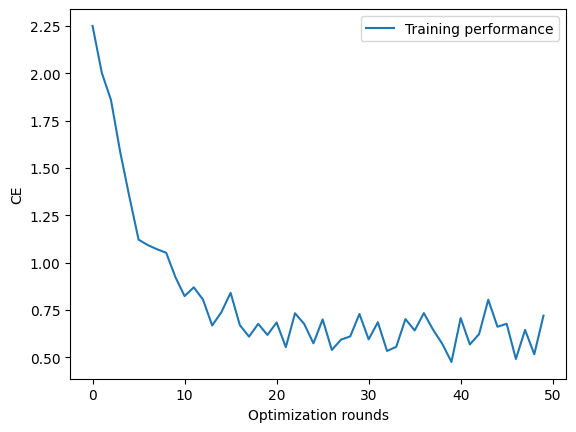

In [254]:
train_losses = [x[1] for x in res.metrics_distributed_fit['losses']]
plt.plot(train_losses, label='Training performance')
plt.legend()
plt.xlabel('Optimization rounds')
plt.ylabel('CE')
plt.show()

# Performance on test set

In [255]:
model_round = 50
net = MultiToOneRNN(hidden_size=hidden_size, LSTM=True)
net.load_state_dict(torch.load(f'./model_round_{model_round}.pth'), strict=False)

<All keys matched successfully>

In [256]:
test_data = []
for i, consumer in enumerate(data):
    if i > 40:
        test_data += data[consumer]
test_loader = DataLoader(ClassificationData(test_data), batch_size=batch_size)

In [257]:
def test(net, test_loader):
    """Test the network on the test set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
    num_layers = net.num_layers
    batch_size = test_loader.batch_size
    val_losses = []
    directions = 1 if not net.bidirectional else 2
    net.eval()
    total_loss = 0.0
    golds = []
    preds = []
    for x, Y in tqdm(test_loader):
        Y = Y.to(DEVICE)
        x = x.to(DEVICE).view(x.shape[0], -1, 1)
        hidden = torch.zeros((num_layers*directions, x.shape[0], net.hidden_size)).to(DEVICE)
        cell = torch.zeros((num_layers*directions, x.shape[0], net.hidden_size)).to(DEVICE)
        outs, hidden, cell = net(x, hidden, cell)
        loss = criterion(outs[:, -1], Y)    
        total_loss += loss.item()
        pred = torch.argmax((F.softmax(outs[:, -1], dim=-1)), dim=-1)
        preds += pred.tolist()
        golds += Y.tolist()
    val_losses.append(total_loss / len(test_loader))
    acc = np.mean((np.array(golds) == np.array(preds)))
    print(f' Test loss: {total_loss / len(test_loader)}, accuracy: {acc}')
    return val_losses, preds, golds

In [258]:
losses, preds, golds = test(net, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4118/4118 [01:15<00:00, 54.53it/s]

 Test loss: 1.0288873806165761, accuracy: 0.6105039465695203


In [259]:
from collections import Counter

In [260]:
count = Counter(preds)
count

Counter({0: 15925,
         8: 2294,
         9: 2917,
         7: 3368,
         5: 2017,
         6: 3010,
         4: 1648,
         2: 575,
         1: 979,
         3: 207})

In [261]:
matrix = confusion_matrix(golds, preds)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'Kettle'),
  Text(0, 1.5, 'Lighting'),
  Text(0, 2.5, 'Refrigerator'),
  Text(0, 3.5, 'Water heater'),
  Text(0, 4.5, 'Washing Machine'),
  Text(0, 5.5, 'Microwave'),
  Text(0, 6.5, 'TV'),
  Text(0, 7.5, 'Dryer'),
  Text(0, 8.5, 'AC'),
  Text(0, 9.5, 'Dish washer')])

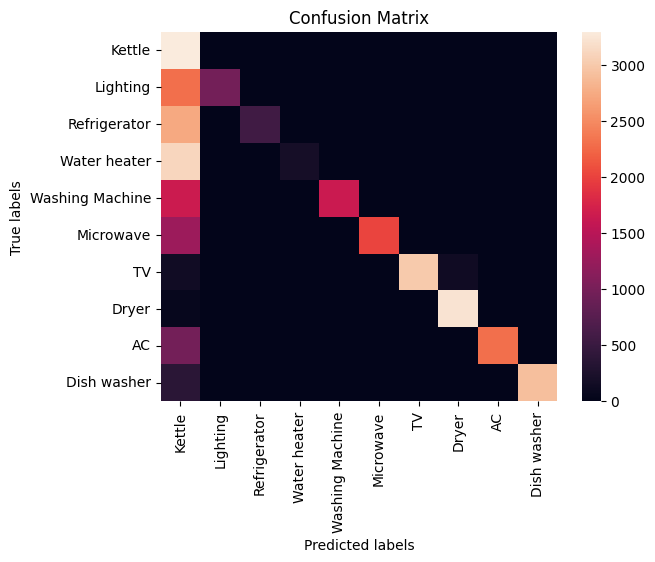

In [262]:
ax= plt.subplot()
sns.heatmap(matrix, annot=False, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(l2idx.keys())
ax.yaxis.set_ticklabels(l2idx.keys())
plt.xticks(rotation=90)
plt.yticks(rotation=0)